# Tesla Stock Prediction Project

# Introduction

In today’s fast-paced financial environment, predicting stock market trends has become a crucial task for investors, analysts, and researchers alike. With the high volatility and complex patterns inherent in stock data, robust forecasting methods are essential to make informed decisions. This project aims to apply classical time series models—ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA)—to analyze and forecast the stock price movements of Tesla Inc. (TSLA).

The primary focus is on two key datasets:

- Tesla’s daily Close price

- Percentage change in Close price (returns)

Using historical stock data, the project explores model building, parameter tuning based on ACF and PACF plots, data transformation techniques such as differencing and Box-Cox transformation, and seasonal analysis. The performance of both ARIMA and SARIMA models is evaluated using standard metrics such as MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error).

Through this analysis, the project highlights the practical applications and limitations of time series models in financial forecasting and provides insights into Tesla’s price dynamics over time.

# Initial Overview & Data Loading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Import Tesla Stock Data
# Set your Alpha Vantage API key and stock symbol
api_key = "LWSVTNIY4R7I023Z"
symbol = "TSLA"
# Create TimeSeries object to fetch daily stock data in pandas format
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch full daily historical stock data for Tesla (TSLA)
df_tesla, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
# Sort data by date in ascending order (oldest to newest)
df_tesla.sort_index(inplace=True)

df_tesla.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0


# Data Cleaning & Manipulation

In [3]:
type(df_tesla)

pandas.core.frame.DataFrame

In [4]:
print(df_tesla.columns)

Index(['1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')


In [5]:
# Rename columns for better readability
df_tesla = df_tesla.rename(columns={
    '4. close': 'Close',
    '2. high': 'High',
    '3. low': 'Low',
    '1. open': 'Open',
    '5. volume': 'Volume'
})

# Rename the index to 'Date' for clarity
df_tesla.index.name = "Date"
df_tesla

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0
...,...,...,...,...,...
2025-06-13,313.97,332.9900,313.30,325.31,128964279.0
2025-06-16,331.29,332.0500,326.41,329.13,83925858.0
2025-06-17,326.09,327.2600,314.74,316.35,88282669.0


In [6]:
df_tesla.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [7]:
type(df_tesla.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [8]:
df_tesla.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [9]:
df_tesla.index.duplicated().sum()

np.int64(0)

In [10]:
df_tesla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3768 entries, 2010-06-29 to 2025-06-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3768 non-null   float64
 1   High    3768 non-null   float64
 2   Low     3768 non-null   float64
 3   Close   3768 non-null   float64
 4   Volume  3768 non-null   float64
dtypes: float64(5)
memory usage: 305.7 KB


In [11]:
df_tesla.describe(include='all')

,Open,High,Low,Close,Volume
count,3768.000000,3768.000000,3768.000000,3768.000000,3.768000e+03
mean,303.175500,309.812250,296.200243,303.222702,2.947351e+07
std,278.485924,285.994359,270.644085,278.664935,4.503957e+07
min,16.140000,16.630000,14.980000,15.800000,1.185000e+05
25%,170.015000,173.775000,166.166250,169.847500,3.560756e+06
50%,235.650000,240.154800,231.345000,236.170000,7.795422e+06
75%,337.555000,343.970000,331.307500,336.250000,2.969071e+07
max,2295.120000,2318.490000,2186.520000,2238.750000,3.065906e+08


# Exploratory Data Analysis

<Axes: xlabel='Date'>

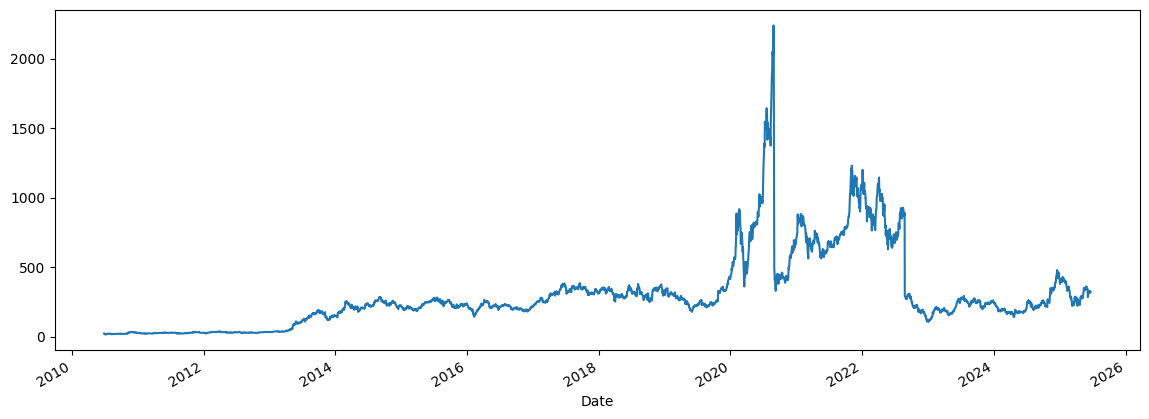

In [12]:
df_tesla['Close'].plot(figsize=(14,5))

<Axes: xlabel='Date'>

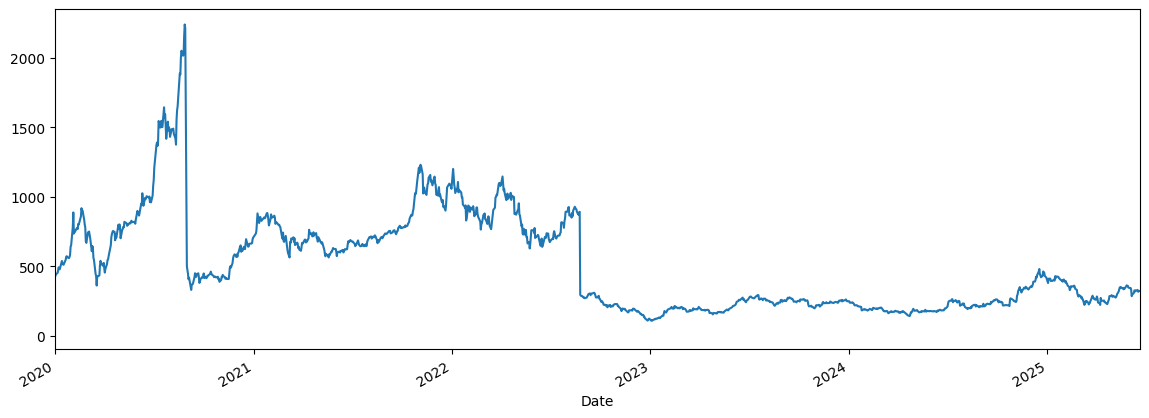

In [13]:
df_tesla['Close'].plot(xlim=['2020-01-01','2025-06-20'], figsize=(14,5))

<Axes: xlabel='Date'>

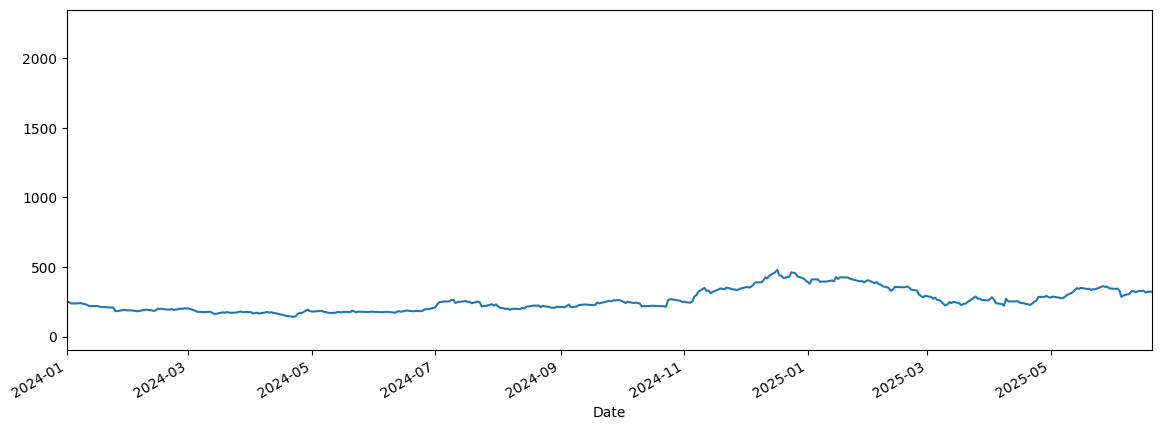

In [14]:
df_tesla['Close'].plot(xlim=['2024-01-01','2025-06-20'], figsize=(14,5))

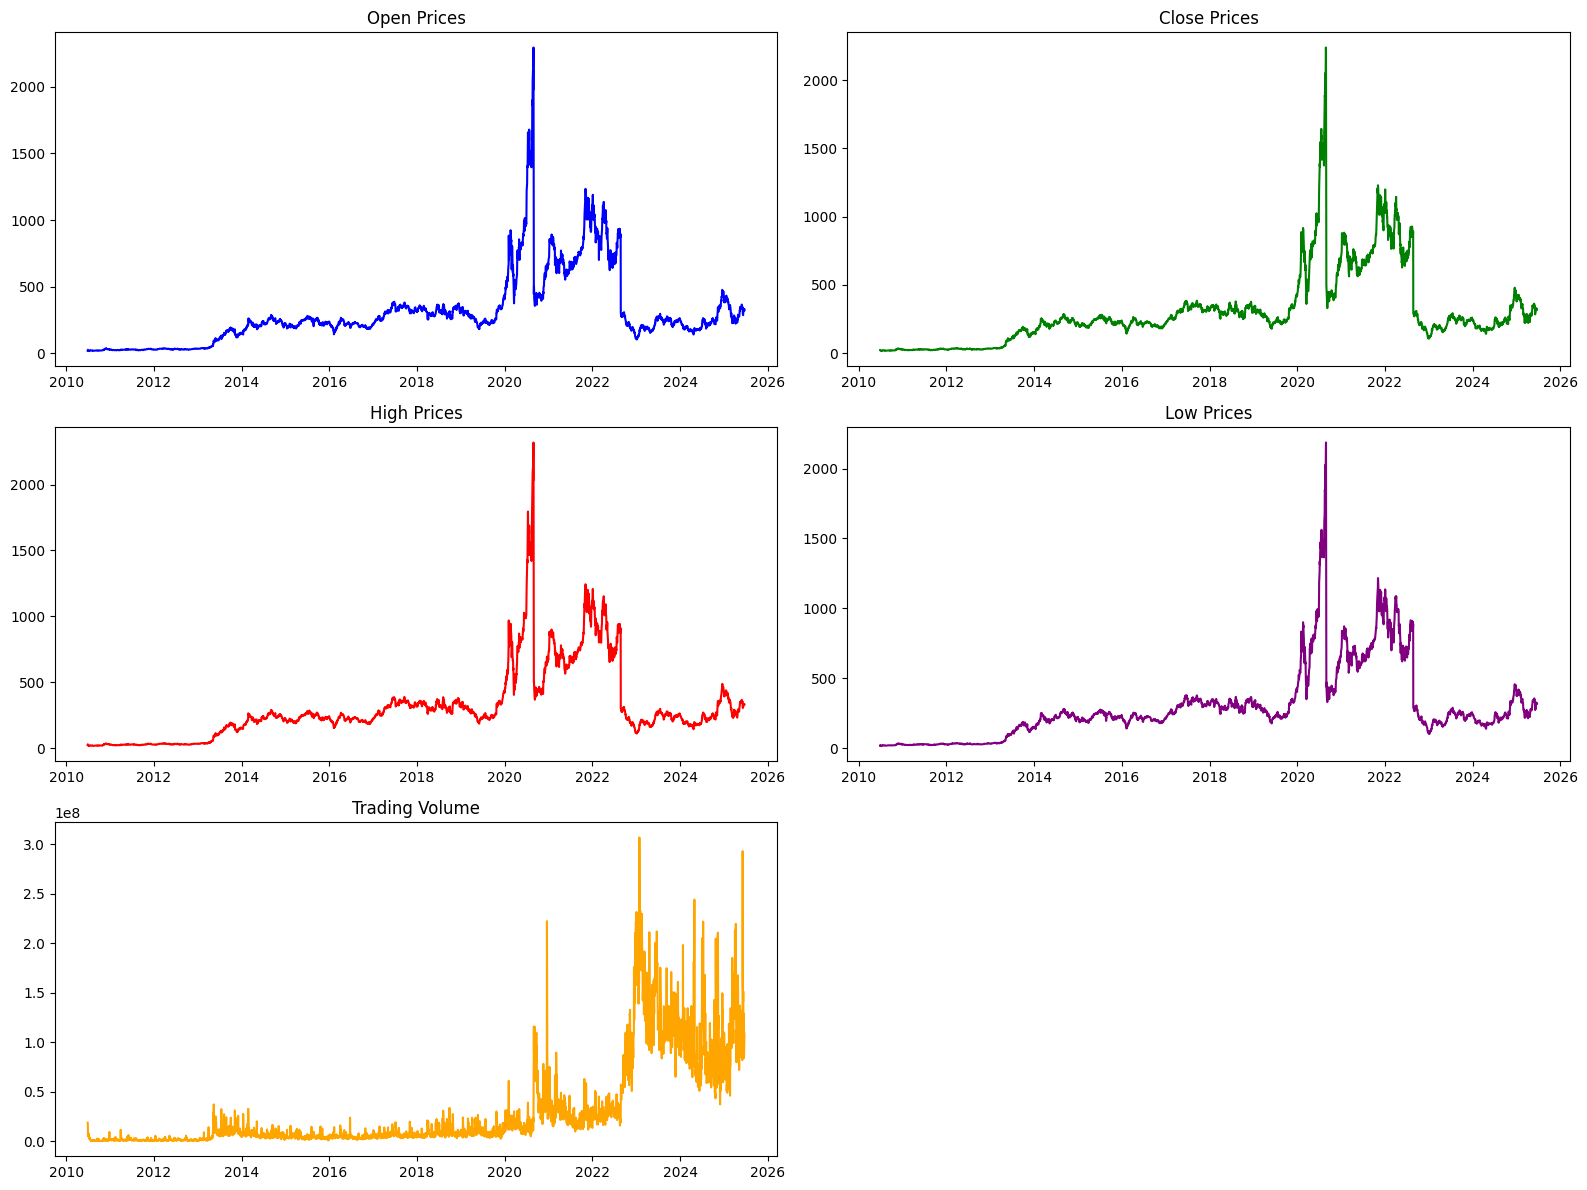

In [15]:
plt.figure(figsize=[16,12])

plt.subplot(321)
plt.plot(df_tesla.index, df_tesla['Open'], color="blue")
plt.title("Open Prices")

plt.subplot(322)
plt.plot(df_tesla.index, df_tesla['Close'], color="green")
plt.title("Close Prices")

plt.subplot(323)
plt.plot(df_tesla.index, df_tesla['High'], color="red")
plt.title("High Prices")

plt.subplot(324)
plt.plot(df_tesla.index, df_tesla['Low'], color="purple")
plt.title("Low Prices")

plt.subplot(325)
plt.plot(df_tesla.index, df_tesla['Volume'], color="orange")
plt.title("Trading Volume")

plt.tight_layout()
plt.show()

# Updated Data for Analysis

In [16]:
# Filter data for the selected date range
df_tesla_modified = df_tesla.loc['2024-06-01':'2025-06-20']

In [17]:
# Ensure index is in datetime format
df_tesla_modified.index = pd.to_datetime(df_tesla_modified.index)

# Generate a business day index for the full date range
full_index = pd.date_range(start=df_tesla_modified.index.min(),
                           end=df_tesla_modified.index.max(),
                           freq='B')  # 'B' stands for business days

# Reindex the DataFrame to include all business days
df_tesla_modified = df_tesla_modified.reindex(full_index)

# Forward-fill missing values to handle non-trading days
df_tesla_modified.fillna(method='ffill', inplace=True)
df_tesla_modified

/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/691408561.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tesla_modified.fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Volume
2024-06-03,178.130,182.6389,174.49,176.29,68568920.0
2024-06-04,174.775,177.7550,174.00,174.77,60056340.0
2024-06-05,175.350,176.1500,172.13,175.00,57953756.0
2024-06-06,174.600,179.7300,172.73,177.94,69887024.0
2024-06-07,176.130,179.3500,175.58,177.48,56244932.0
...,...,...,...,...,...
2025-06-16,331.290,332.0500,326.41,329.13,83925858.0
2025-06-17,326.090,327.2600,314.74,316.35,88282669.0
2025-06-18,317.310,329.3200,315.45,322.05,95137686.0
2025-06-19,317.310,329.3200,315.45,322.05,95137686.0


# Will be Using 2 categories to predict Tesla Stock:

1. Using original close value from our dataset 'Close'.

2. And another using percentage change value of close 'Pct_change_close'. {df['Pct_change_close'] = df['Close'].pct_change()}


# Let's Start with 1. 

## Decomposition of Data

### Classical Decomposition

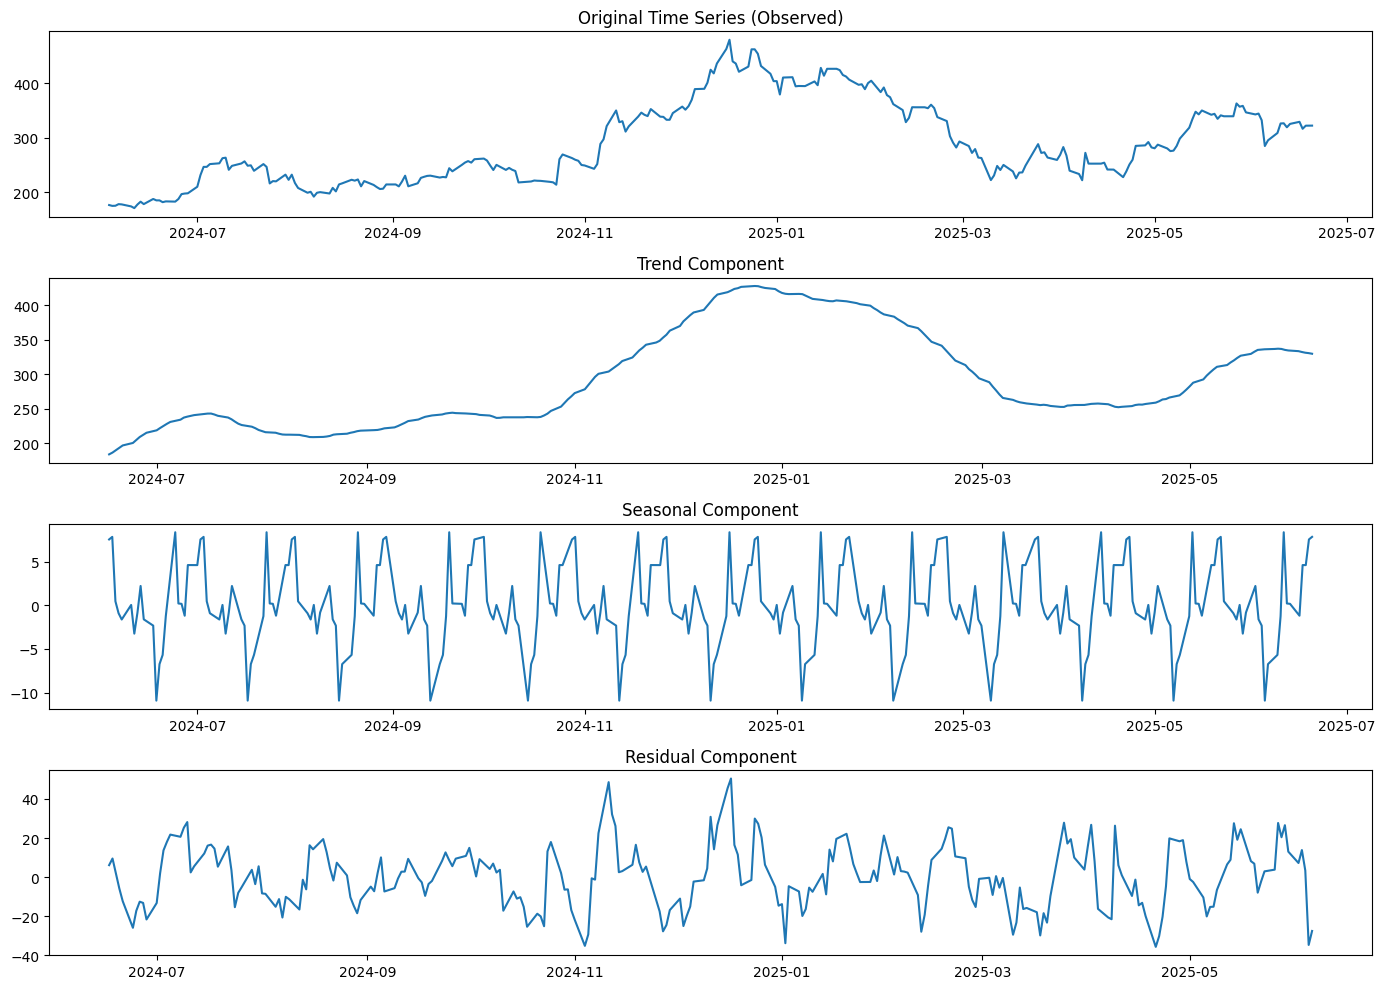

In [18]:
# Perform seasonal decomposition (weekly seasonality assumed with period=21)
decomposition = seasonal_decompose(df_tesla_modified['Close'], model='additive', period=21)

# Extract decomposition components
Real_observed_data = decomposition.observed
data_decomposed_trend = decomposition.trend
data_decomposed_seasonal = decomposition.seasonal
data_decomposed_residual = decomposition.resid

# Plot decomposition components
plt.figure(figsize=(14, 10))

# Plot the observed data (Original time series)
plt.subplot(411)
plt.plot(Real_observed_data)
plt.title("Original Time Series (Observed)")

# Plot the trend component
plt.subplot(412)
plt.plot(data_decomposed_trend)
plt.title("Trend Component")

# Plot the seasonal component
plt.subplot(413)
plt.plot(data_decomposed_seasonal)
plt.title("Seasonal Component")

# Plot the residual component
plt.subplot(414)
plt.plot(data_decomposed_residual)
plt.title("Residual Component")

plt.tight_layout()
plt.show()

### STL Decomposition

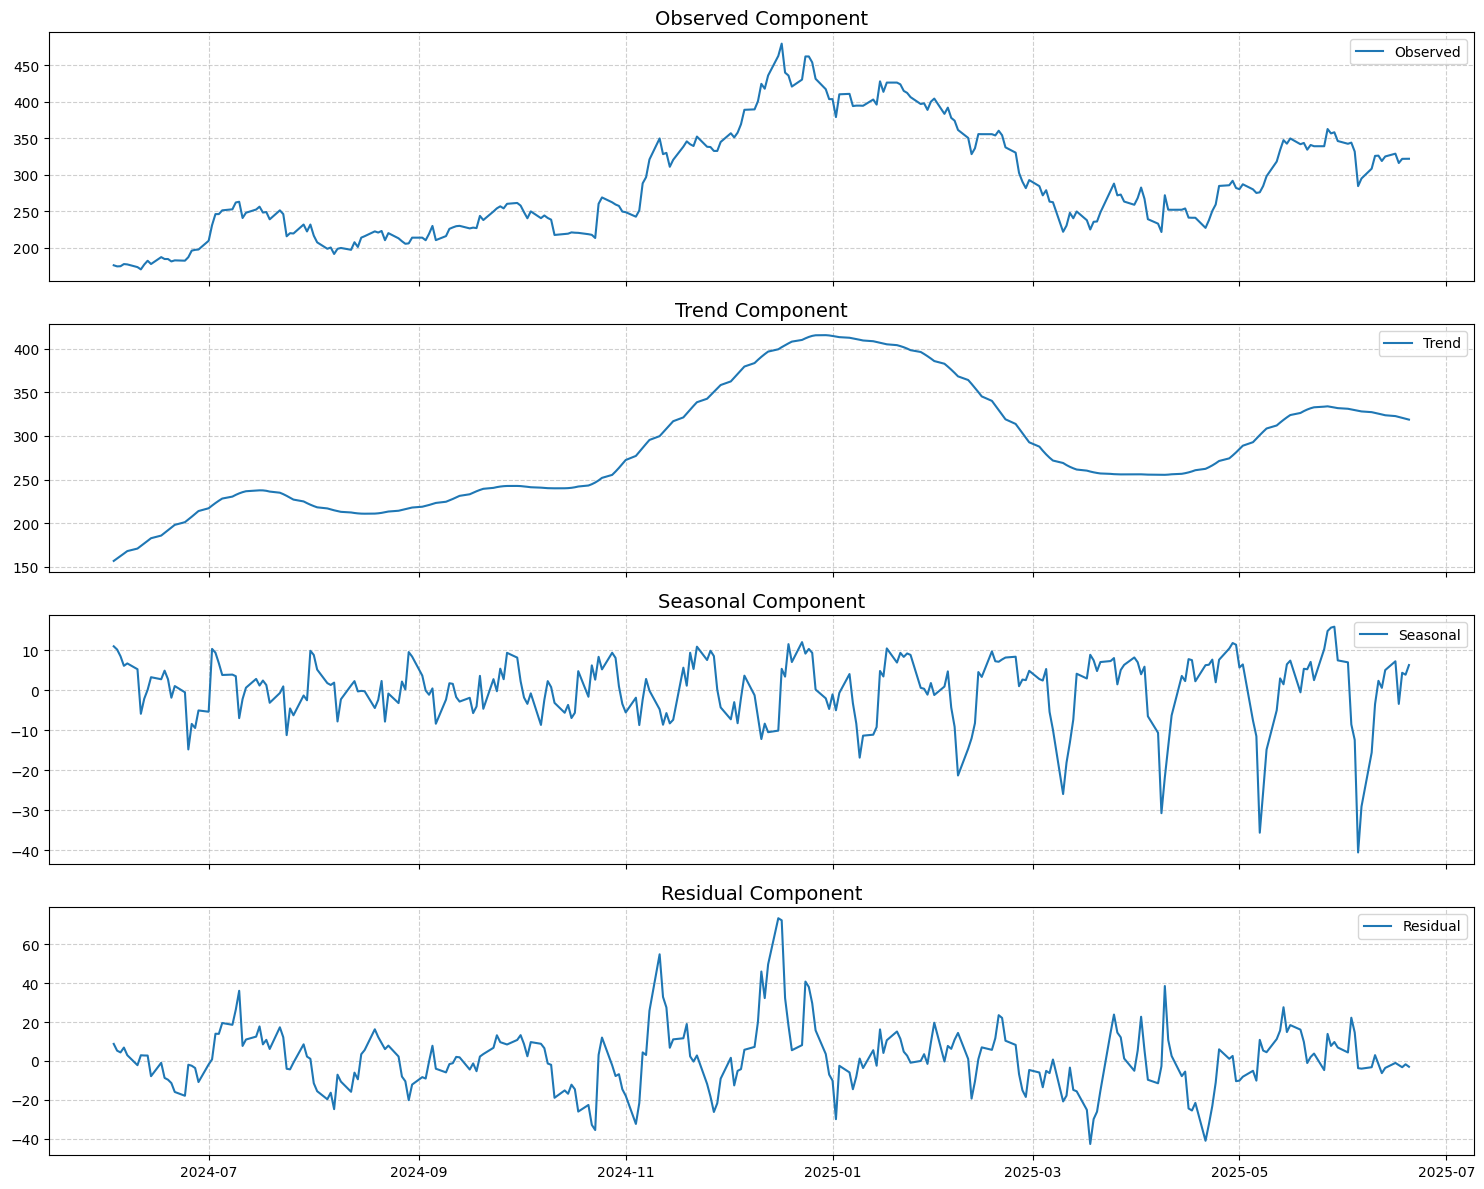

In [19]:
# STL Decomposition Parameters (configurable)
period = 21        # Seasonality period (e.g., 7 for weekly, 21 for monthly on business days)
seasonal = 13      # Length of seasonal smoother (odd integer, e.g., 7, 13, 21)
robust = True      # Use robust fitting to minimize impact of outliers

# Perform STL decomposition
stl = STL(df_tesla_modified['Close'], period=period, seasonal=seasonal, robust=robust)
result = stl.fit()

# Extract STL components
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
series_list = [df_tesla_modified['Close'], result.trend, result.seasonal, result.resid]

# Plot STL decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

for ax, name, series in zip(axes, components, series_list):
    ax.plot(series, label=name, linewidth=1.5)
    ax.set_title(f"{name} Component", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Stationarity Check

### ADF Test

#Augmented Dickey-Fuller (ADF) Test Interpretation Guide

#result[0] - ADF Statistic:
  - Measures the strength of stationarity.
  - More negative => Stronger evidence the series is stationary.
  - Compare against critical values for confirmation.

#result[1] - p-value:
  - Probability that the series is non-stationary.
  - If p-value < 0.05 => Reject null hypothesis => Series is likely stationary.

#result[4] - Critical Values:
  - Threshold values at 1%, 5%, and 10% confidence levels.
  - If ADF Statistic < critical value (e.g., at 5%), the series is considered stationary.

#Summary:
  - If p-value < 0.05 and ADF Statistic < critical value, conclude the time series is stationary.

In [20]:
# Perform the ADF test
adf_result_close = adfuller(df_tesla_modified['Close'])

print('ADF Statistic:', adf_result_close[0])     # The test statistic (more negative means more likely to be stationary).
print('p-value:', adf_result_close[1])           # Probability that the series is non-stationary (lower is better, typically < 0.05).
print("Critical Values:", adf_result_close[4])   # Threshold values at different confidence levels (1%, 5%, 10%). 

# Check if the data is stationary
if adf_result_close[1] < 0.05:
    print("\nThe data is stationary")
else:
    print("\nThe data is non-stationary")

ADF Statistic: -1.7750704316481984
p-value: 0.3929068691688198
Critical Values: {'1%': np.float64(-3.4544435065994437), '5%': np.float64(-2.8721468827772774), '10%': np.float64(-2.572422013959188)}

The data is non-stationary


### KPSS Test

#Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test Interpretation Guide

#result[0] - KPSS Statistic:
   - Measures deviation from stationarity.
   - Higher values => Stronger evidence that the series is non-stationary.
   - Compare against critical values for decision-making.

#result[1] - p-value:
   - Probability that the series is stationary.
   - If p-value < 0.05 => Reject null hypothesis => Series is likely non-stationary.

#result[3] - Critical Values:
   - Threshold values at 10%, 5%, 2.5%, and 1% levels.
   - If KPSS Statistic > critical value => Reject null hypothesis => Series is non-stationary.

#Summary:
   - KPSS null hypothesis: Series is stationary.
   - If p-value > 0.05 or KPSS Statistic < critical value, the series is considered stationary.

In [21]:
# Run KPSS test
kpss_result_close = kpss(df_tesla_modified['Close'], regression='ct', nlags="auto")

# Extracting and printing the results
print("KPSS Statistic:", kpss_result_close[0])
print("p-value:", kpss_result_close[1])
print("Critical Values:", kpss_result_close[3])

# Check if the data is stationary
if kpss_result_close[1] < 0.05:
    print("\nThe data is not stationary (reject H0).")
else:
    print("\nThe data is stationary (fail to reject H0).")

KPSS Statistic: 0.35401768542061385
p-value: 0.01
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is not stationary (reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/1299824157.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_close = kpss(df_tesla_modified['Close'], regression='ct', nlags="auto")


## Transforming Data for constant Variance & Mean using Box-cox & Differencing

### Apply Box-cox

In [22]:
# Apply the Box-Cox transformation
df_tesla_modified['Close_boxcox'], lambda_bc = boxcox(df_tesla_modified['Close'])
df_tesla_modified

,Open,High,Low,Close,Volume,Close_boxcox
2024-06-03,178.130,182.6389,174.49,176.29,68568920.0,2.461230
2024-06-04,174.775,177.7550,174.00,174.77,60056340.0,2.459689
2024-06-05,175.350,176.1500,172.13,175.00,57953756.0,2.459924
2024-06-06,174.600,179.7300,172.73,177.94,69887024.0,2.462882
2024-06-07,176.130,179.3500,175.58,177.48,56244932.0,2.462423
...,...,...,...,...,...,...
2025-06-16,331.290,332.0500,326.41,329.13,83925858.0,2.561307
2025-06-17,326.090,327.2600,314.74,316.35,88282669.0,2.555560
2025-06-18,317.310,329.3200,315.45,322.05,95137686.0,2.558161
2025-06-19,317.310,329.3200,315.45,322.05,95137686.0,2.558161


### Checking Stationarity for Box-cox data

#### ADF Test on Box-cox

In [23]:
# Perform the ADF test
adf_result_boxcox = adfuller(df_tesla_modified['Close_boxcox'])

print('ADF Statistic:', adf_result_boxcox[0])     
print('p-value:', adf_result_boxcox[1])           
print("Critical Values:", adf_result_boxcox[4])   

# Check if the data is stationary
if adf_result_boxcox[1] < 0.05:
    print("\nThe data is stationary")
else:
    print("\nThe data is non-stationary")

ADF Statistic: -2.041315404296212
p-value: 0.268756541380398
Critical Values: {'1%': np.float64(-3.4544435065994437), '5%': np.float64(-2.8721468827772774), '10%': np.float64(-2.572422013959188)}

The data is non-stationary


#### KPSS Test on Box-cox

In [24]:
# Run KPSS test
kpss_result_boxcox = kpss(df_tesla_modified['Close_boxcox'], regression='ct', nlags="auto")

# Extracting and printing the results
print("KPSS Statistic:", kpss_result_boxcox[0])
print("p-value:", kpss_result_boxcox[1])
print("Critical Values:", kpss_result_boxcox[3])

# Check if the data is stationary
if kpss_result_boxcox[1] < 0.05:
    print("\nThe data is not stationary (reject H0).")
else:
    print("\nThe data is stationary (fail to reject H0).")

KPSS Statistic: 0.36504550477233433
p-value: 0.01
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is not stationary (reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/3691730458.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_boxcox = kpss(df_tesla_modified['Close_boxcox'], regression='ct', nlags="auto")


From the above tests we can seen that box-cox data is not stationary. So, will need to perform stationarity on data

### Apply differencing on Box-cox data for Stationarity

In [25]:
df_tesla_modified['Close_diff'] = df_tesla_modified['Close_boxcox'].diff()
df_tesla_modified.dropna(subset=['Close_diff'], inplace=True)
df_tesla_modified

,Open,High,Low,Close,Volume,Close_boxcox,Close_diff
2024-06-04,174.775,177.755,174.00,174.77,60056340.0,2.459689,-0.001540
2024-06-05,175.350,176.150,172.13,175.00,57953756.0,2.459924,0.000234
2024-06-06,174.600,179.730,172.73,177.94,69887024.0,2.462882,0.002958
2024-06-07,176.130,179.350,175.58,177.48,56244932.0,2.462423,-0.000458
2024-06-10,176.060,178.570,173.17,173.79,50869682.0,2.458687,-0.003736
...,...,...,...,...,...,...,...
2025-06-16,331.290,332.050,326.41,329.13,83925858.0,2.561307,0.001686
2025-06-17,326.090,327.260,314.74,316.35,88282669.0,2.555560,-0.005747
2025-06-18,317.310,329.320,315.45,322.05,95137686.0,2.558161,0.002601
2025-06-19,317.310,329.320,315.45,322.05,95137686.0,2.558161,0.000000


## Checking Stationarity after Differencing

#### ADF Test on Differenced data

In [26]:
adf_result_diff = adfuller(df_tesla_modified['Close_diff'])

print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print(f"Critical Values: {adf_result_diff[4]}")

# Interpret the result
if adf_result_diff[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is non-stationary")

ADF Statistic: -16.63198305168885
p-value: 1.662914435462378e-29
Critical Values: {'1%': np.float64(-3.45453261164607), '5%': np.float64(-2.8721859575020017), '10%': np.float64(-2.572442854861866)}
The data is stationary


#### KPSS Test on Differenced data

In [27]:
kpss_result_diff = kpss(df_tesla_modified['Close_diff'], regression='c', nlags="auto")

# Extracting and printing the results
print(f"KPSS Statistic: {kpss_result_diff[0]:.6f}")
print(f"p-value: {kpss_result_diff[1]:.4f}")
print("Critical Values:", kpss_result_diff[3])

# Check if the data is stationary
if kpss_result_diff[1] < 0.05:
    print("The data is not stationary (reject H0).")
else:
    print("The data is stationary (fail to reject H0).")

KPSS Statistic: 0.129127
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is stationary (fail to reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/295492571.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(df_tesla_modified['Close_diff'], regression='c', nlags="auto")


From the above results we can see that the data is stationary

### Plot ACF & PACF

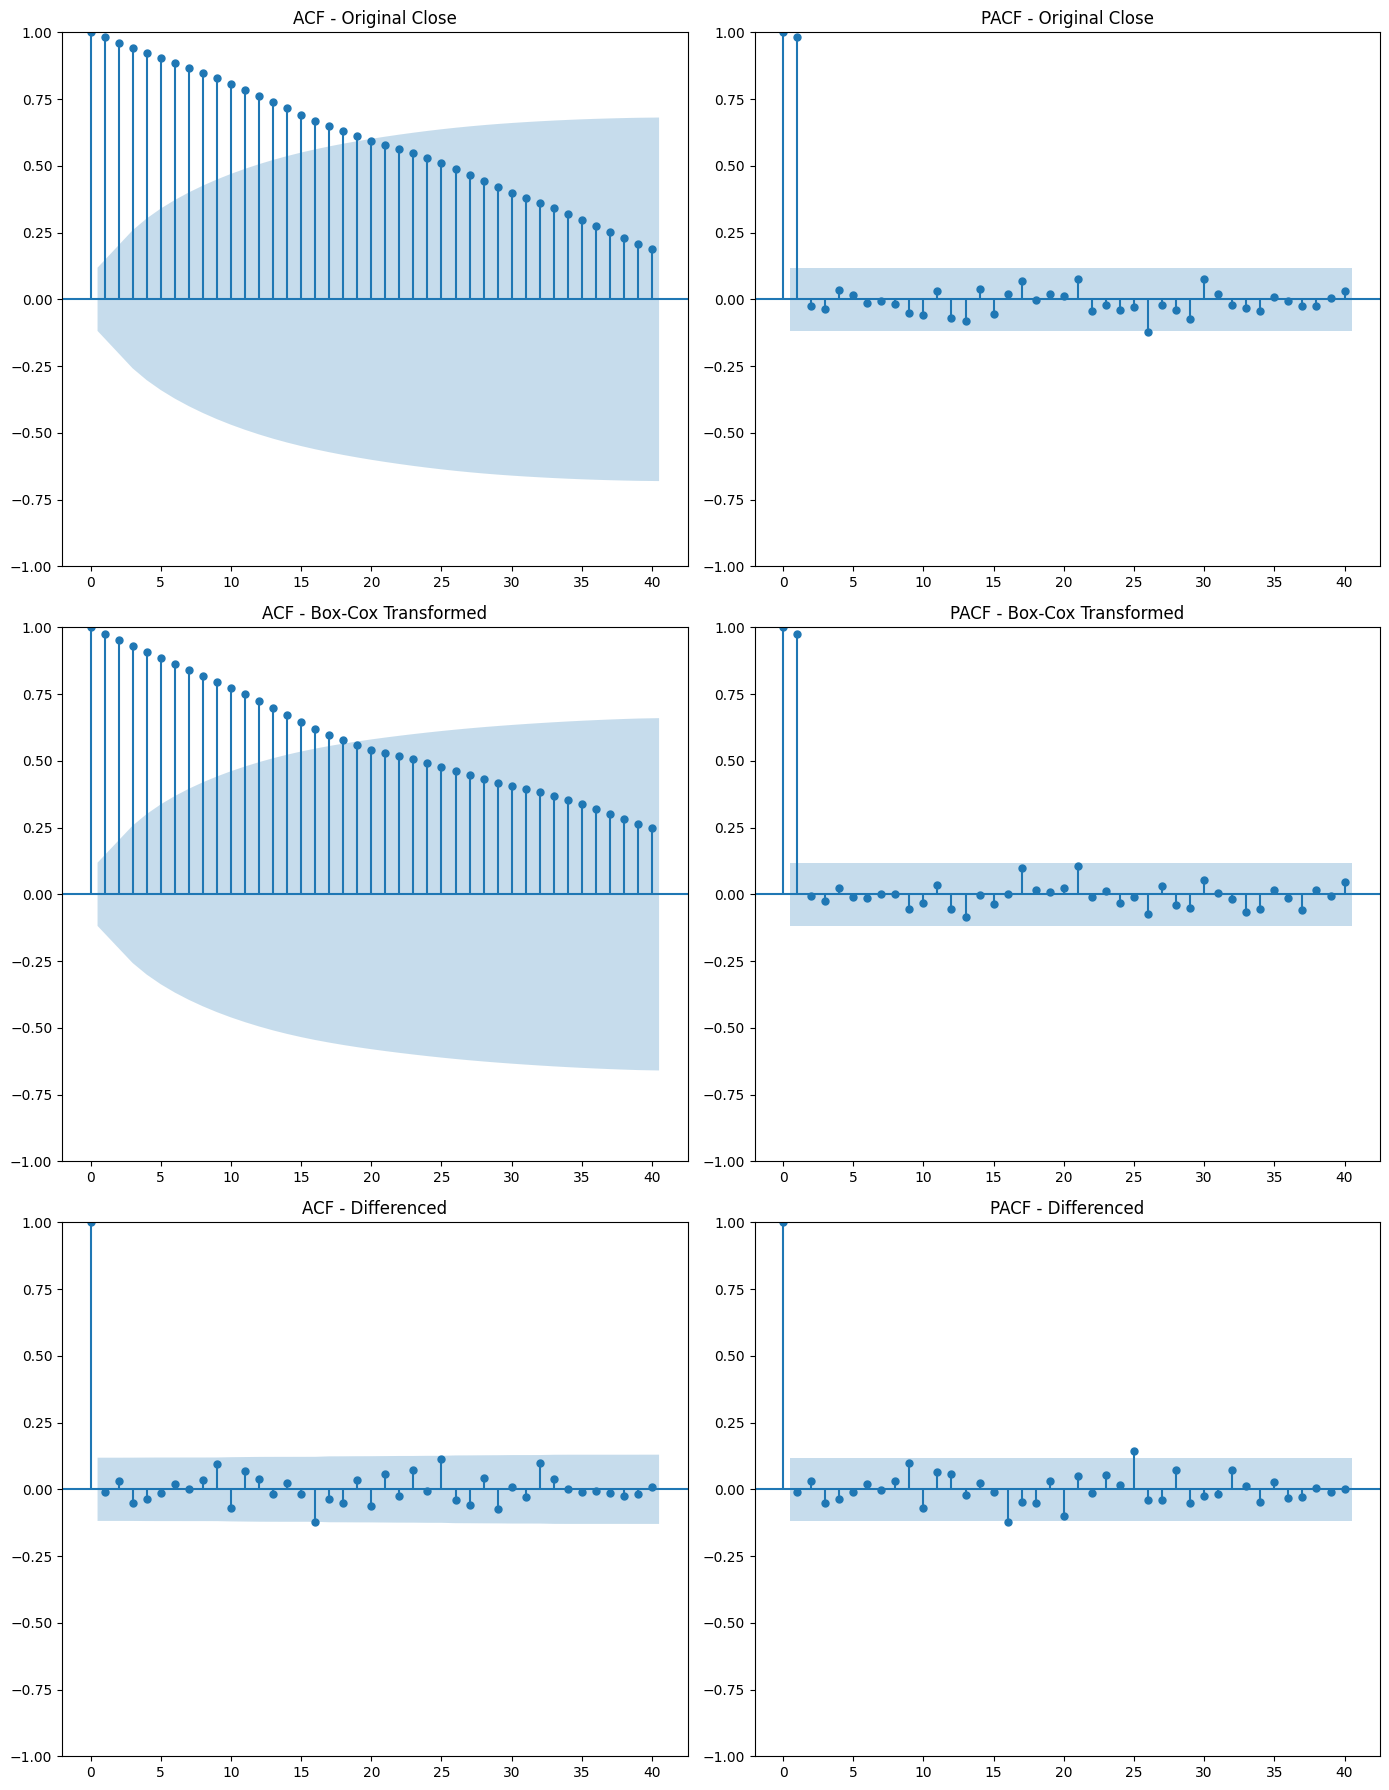

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# 1. Original Close
plot_acf(df_tesla_modified['Close'], lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Original Close")
plot_pacf(df_tesla_modified['Close'], lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Original Close")

# 2. Box-Cox Transformed
plot_acf(df_tesla_modified['Close_boxcox'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF - Box-Cox Transformed")
plot_pacf(df_tesla_modified['Close_boxcox'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF - Box-Cox Transformed")

# 3. Differenced
plot_acf(df_tesla_modified['Close_diff'], lags=40, ax=axes[2, 0])
axes[2, 0].set_title("ACF - Differenced")
plot_pacf(df_tesla_modified['Close_diff'], lags=40, ax=axes[2, 1])
axes[2, 1].set_title("PACF - Differenced")

plt.tight_layout()
plt.show()

For ARIMA model Will be using Box-cox transformed data, with p=1, d=1, q=0 from the above plots

## ARIMA Model

In [29]:
#Splitting data into training and test sets (e.g., last 10% for testing)
close_diff_cb = df_tesla_modified['Close_boxcox'].dropna()
train_size_cb = int(len(close_diff_cb) * 0.9)
train_cb, test_cb = close_diff_cb[:train_size_cb], close_diff_cb[train_size_cb:]

ARIMA Model Summary (order=(1,1,0)):
                               SARIMAX Results                                
Dep. Variable:           Close_boxcox   No. Observations:                  246
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 868.663
Date:                Mon, 23 Jun 2025   AIC                          -1733.327
Time:                        17:21:35   BIC                          -1726.324
Sample:                    06-04-2024   HQIC                         -1730.507
                         - 05-13-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0102      0.062     -0.166      0.868      -0.131       0.110
sigma2      4.869e-05    2.6e-06     18.718      0.000    4.36e-05    5.38e-05
Ljung-Box (L1) 

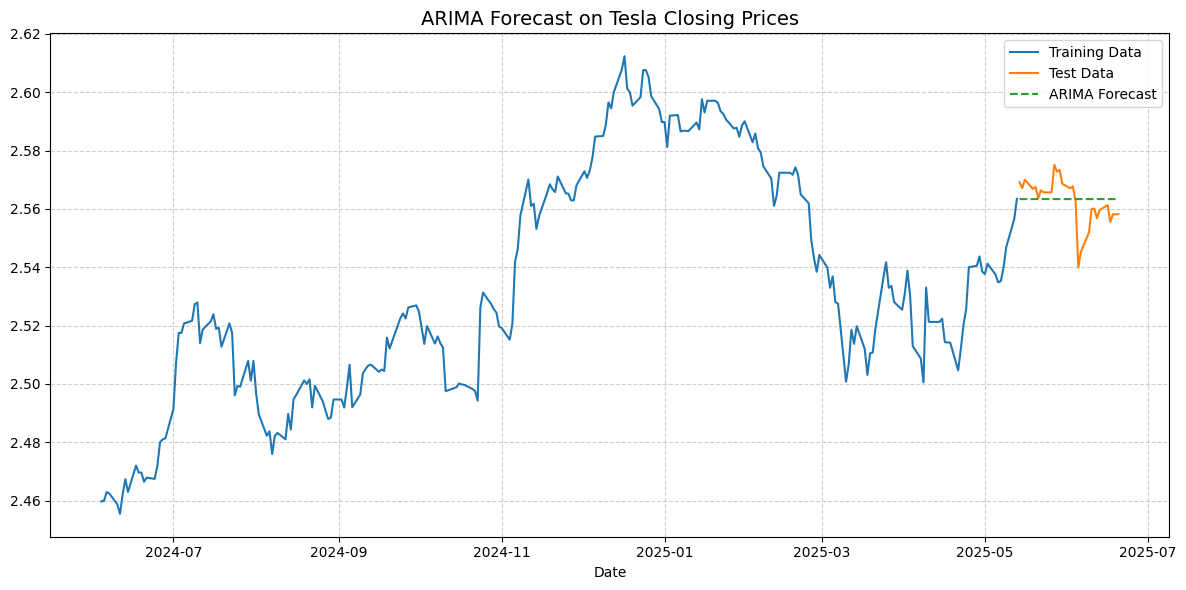

In [30]:
# Fit ARIMA model (Note: ARIMA with order=(1,1,0) is equivalent to ARMA(1,0) on differenced data)
arma_model_cb = ARIMA(train_cb, order=(1, 1, 0)).fit()

# Display model summary
print("ARIMA Model Summary (order=(1,1,0)):")
print(arma_model_cb.summary())

# Forecasting
arma_predictions_cb = arma_model_cb.predict(start=len(train_cb), 
                                            end=len(close_diff_cb)-1, 
                                            dynamic=False)

# Align forecast index with test set
arma_predictions_cb.index = test_cb.index

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_cb, label="Training Data")
plt.plot(test_cb, label="Test Data")
plt.plot(arma_predictions_cb, label="ARIMA Forecast", linestyle="--")
plt.title("ARIMA Forecast on Tesla Closing Prices", fontsize=14)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Evaluation Metrics

In [31]:
# Calculate error metrics
mae_cb = mean_absolute_error(test_cb, arma_predictions_cb)
rmse_cb = np.sqrt(mean_squared_error(test_cb, arma_predictions_cb))
mape_cb = mean_absolute_percentage_error(test_cb, arma_predictions_cb)

print(f"MAE: {mae_cb:.4f}")
print(f"RMSE: {rmse_cb:.4f}")
print(f"MAPE: {mape_cb:.4f}")

MAE: 0.0062
RMSE: 0.0079
MAPE: 0.0024


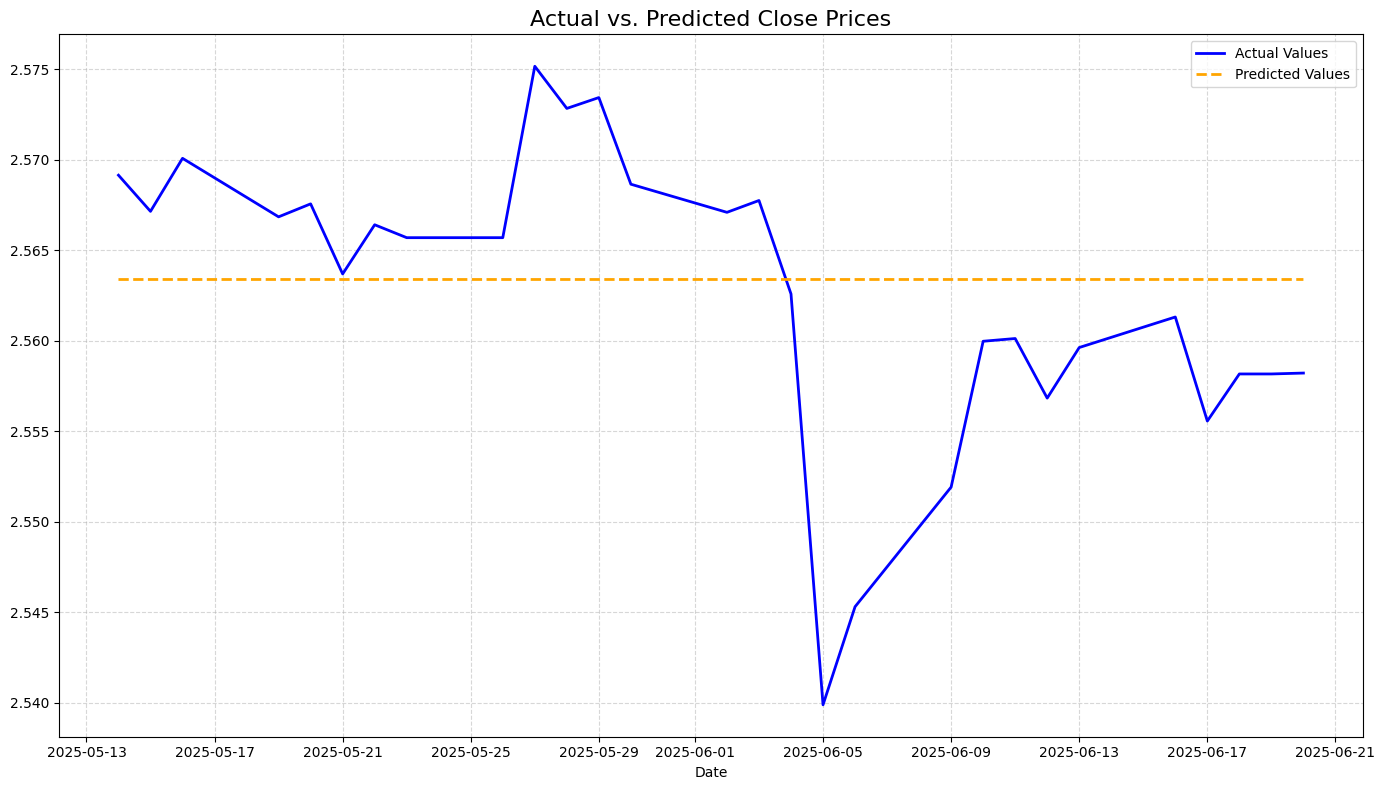

In [32]:
# Plot actual vs predicted values on test set
plt.figure(figsize=(14, 8))
plt.plot(test_cb, label="Actual Values", color="blue", linewidth=2)
plt.plot(arma_predictions_cb, label="Predicted Values", color="orange", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted Close Prices", fontsize=16)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

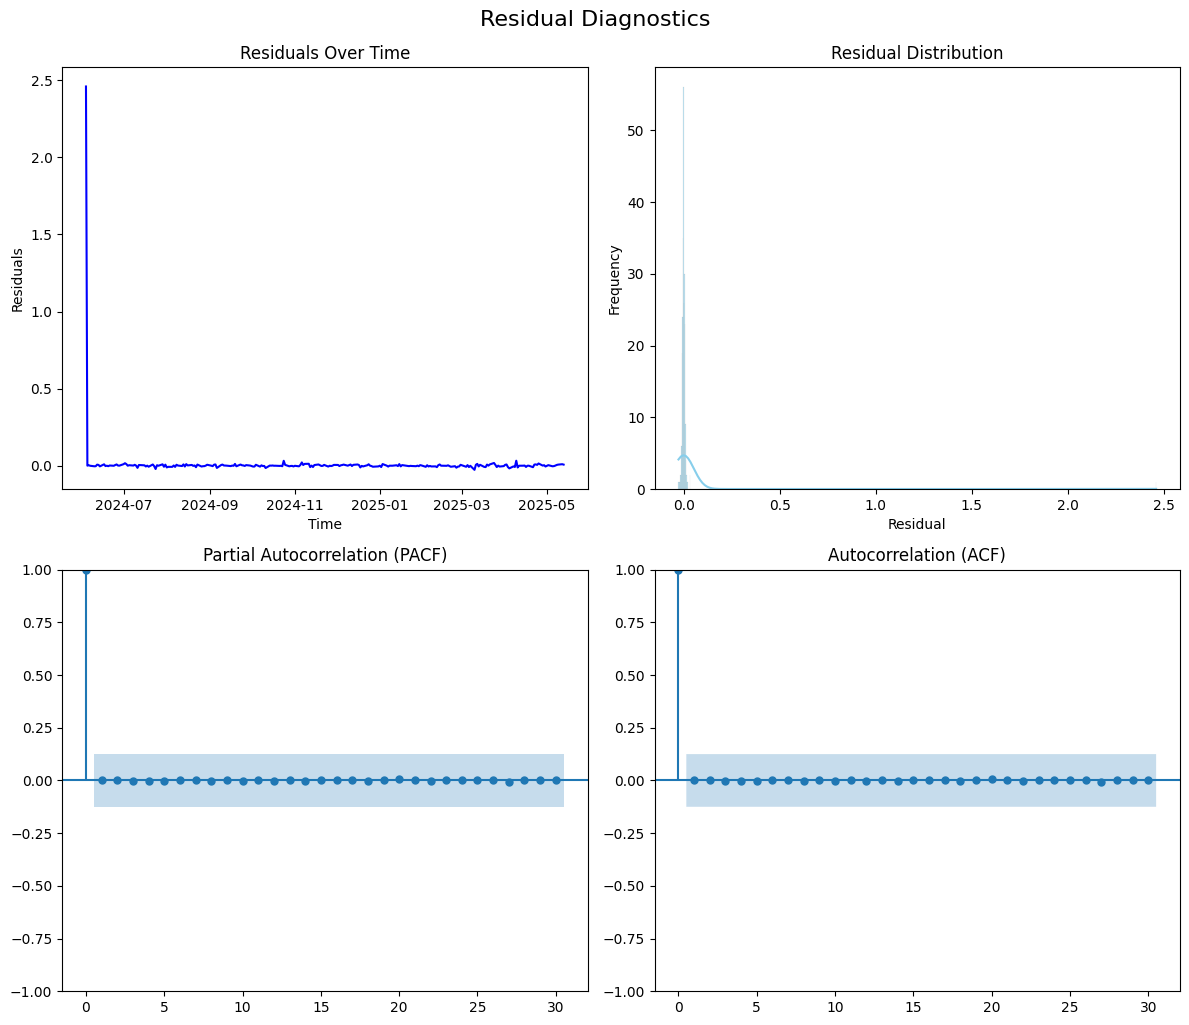

In [33]:
# Plot residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Line plot of residuals
axes[0, 0].plot(arma_model_cb.resid, color='blue')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# Histogram of residuals with KDE
sns.histplot(arma_model_cb.resid, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# PACF plot of residuals
plot_pacf(arma_model_cb.resid, lags=30, ax=axes[1, 0])
axes[1, 0].set_title("Partial Autocorrelation (PACF)")

# ACF plot of residuals
plot_acf(arma_model_cb.resid, lags=30, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation (ACF)")

plt.tight_layout()
plt.suptitle("Residual Diagnostics", fontsize=16, y=1.02)
plt.show()


Overall, the model has performed well. 
As the real world Stock data has high volatility, need to apply additional models to better predict volatility & model performance.

## Now Lets Transform the data for seasonality

### First, Lets do Seasonal Differencing

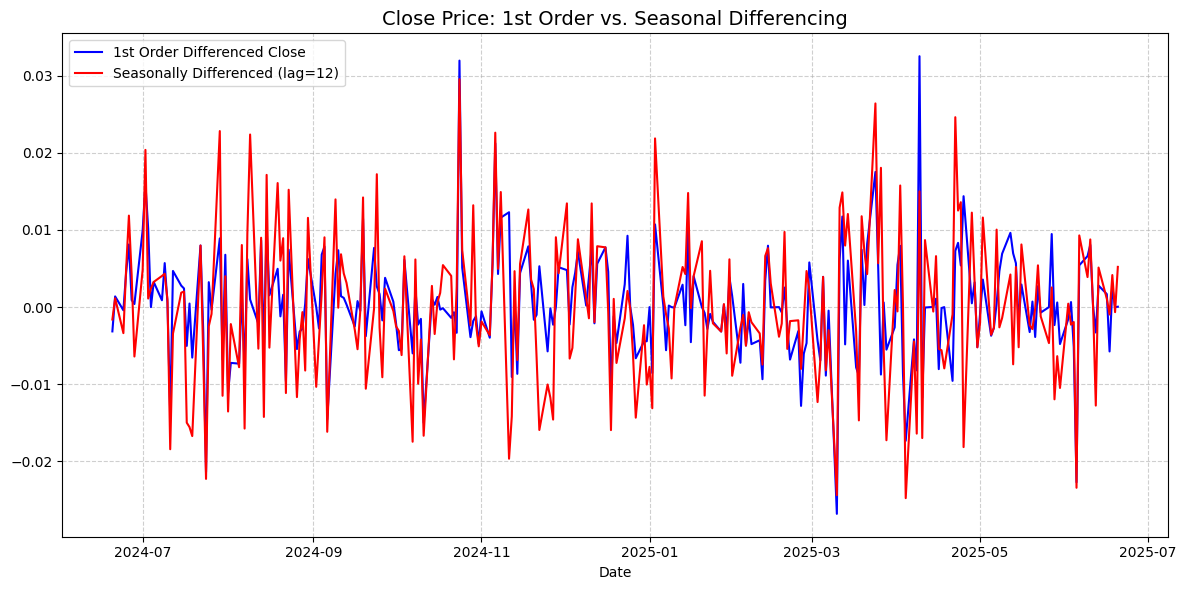

In [34]:
# Create seasonal differencing
df_tesla_modified['Close_diff_12'] = df_tesla_modified['Close_diff'].diff(12)
df_tesla_modified.dropna(subset=['Close_diff_12'], inplace=True)

# Plot the original vs. seasonal differenced series
plt.figure(figsize=(12, 6))

plt.plot(df_tesla_modified['Close_diff'], label='1st Order Differenced Close', color='blue')
plt.plot(df_tesla_modified['Close_diff_12'], label='Seasonally Differenced (lag=12)', color='red')
plt.title('Close Price: 1st Order vs. Seasonal Differencing', fontsize=14)
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Checking Stationarity for Seasonal data

#### ADF Test on Seasonal Differenced data

In [35]:
adf_result_diff_12 = adfuller(df_tesla_modified['Close_diff_12'])

print(f"ADF Statistic: {adf_result_diff_12[0]}")
print(f"p-value: {adf_result_diff_12[1]}")
print(f"Critical Values: {adf_result_diff_12[4]}")

# Interpret the result
if adf_result_diff_12[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is non-stationary")

ADF Statistic: -6.460320560032345
p-value: 1.4486764841060043e-08
Critical Values: {'1%': np.float64(-3.457215237265747), '5%': np.float64(-2.873361841566324), '10%': np.float64(-2.5730700760129555)}
The data is stationary


#### KPSS Test on Seasonal Differenced data

In [36]:
kpss_result_diff_12 = kpss(df_tesla_modified['Close_diff_12'], regression='c', nlags="auto")

# Extracting and printing the results
print(f"KPSS Statistic: {kpss_result_diff_12[0]:.6f}")
print(f"p-value: {kpss_result_diff_12[1]:.4f}")
print(f"Critical Values:", kpss_result_diff_12[3])

# Check if the data is stationary
if kpss_result_diff_12[1] < 0.05:
    print("The data is not stationary (reject H0).")
else:
    print("The data is stationary (fail to reject H0).")

KPSS Statistic: 0.024554
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is stationary (fail to reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/3087168769.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff_12 = kpss(df_tesla_modified['Close_diff_12'], regression='c', nlags="auto")


From the above results we can see that the data is seasonal stationary.

### Plot ACF & PACF for Seasonal

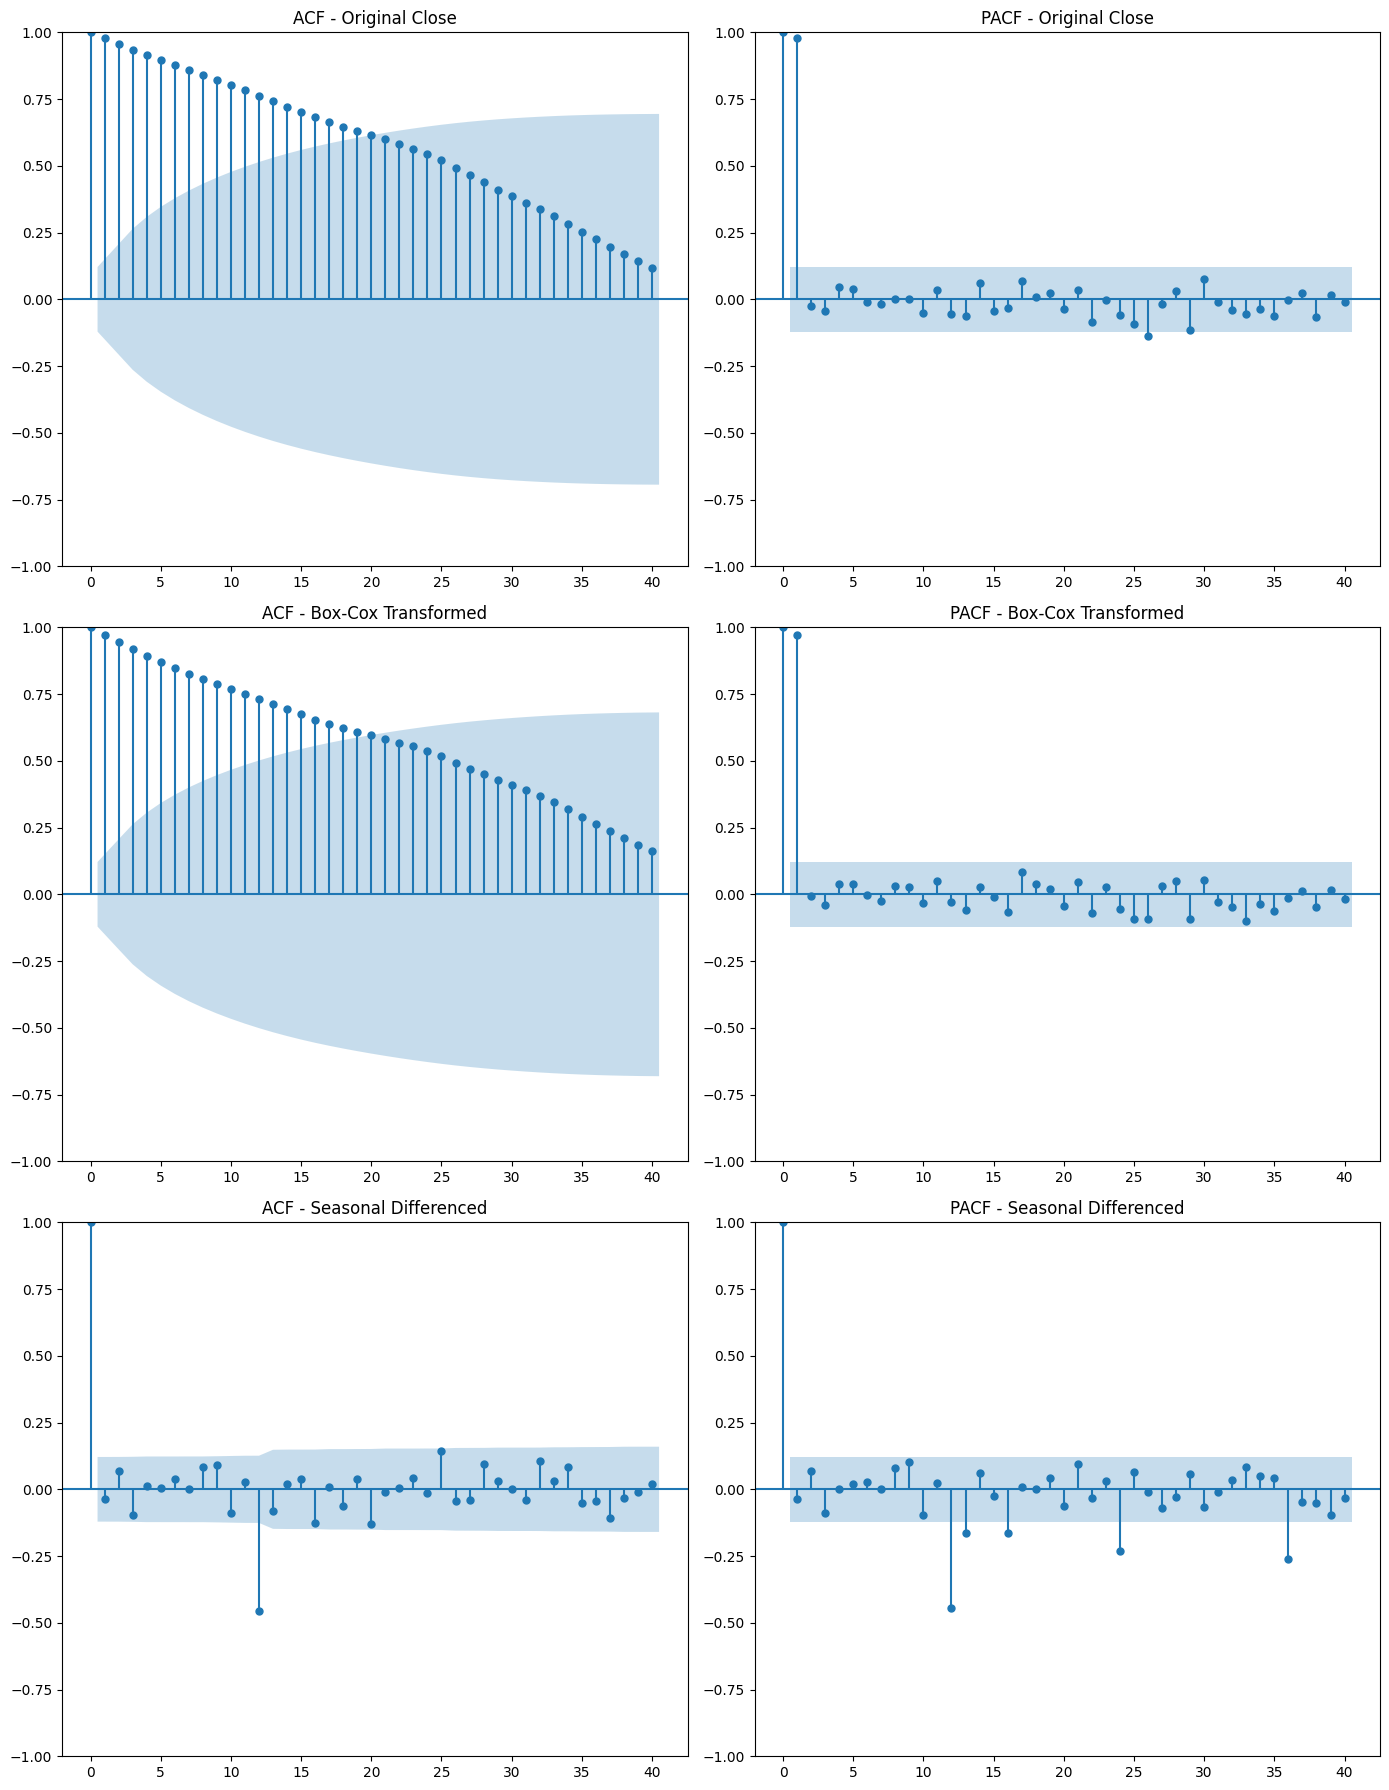

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# 1. Original Close
plot_acf(df_tesla_modified['Close'], lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Original Close")
plot_pacf(df_tesla_modified['Close'], lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Original Close")

# 2. Box-Cox Transformed
plot_acf(df_tesla_modified['Close_boxcox'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF - Box-Cox Transformed")
plot_pacf(df_tesla_modified['Close_boxcox'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF - Box-Cox Transformed")

# 3. Differenced
plot_acf(df_tesla_modified['Close_diff_12'], lags=40, ax=axes[2, 0])
axes[2, 0].set_title("ACF - Seasonal Differenced")
plot_pacf(df_tesla_modified['Close_diff_12'], lags=40, ax=axes[2, 1])
axes[2, 1].set_title("PACF - Seasonal Differenced")

plt.tight_layout()
plt.show()

For SARIMA Model, will be using Seasonal Differenced data for P=1, D=1, Q=1, m=12 from the above plots.

## SARIMA Model

In [38]:
#Splitting data into training and test sets (e.g., last 10% for testing)
close_diff_s = df_tesla_modified['Close_boxcox'].dropna()
train_size_s = int(len(close_diff_s) * 0.9)
train_s, test_s = close_diff_s[:train_size_s], close_diff_s[train_size_s:]

                                      SARIMAX Results                                       
Dep. Variable:                         Close_boxcox   No. Observations:                  235
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 722.391
Date:                              Mon, 23 Jun 2025   AIC                          -1436.782
Time:                                      17:21:36   BIC                          -1423.413
Sample:                                  06-20-2024   HQIC                         -1431.377
                                       - 05-14-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0865      0.068     -1.273      0.203      -0.220       0.047
ar.S.L12      -0.03

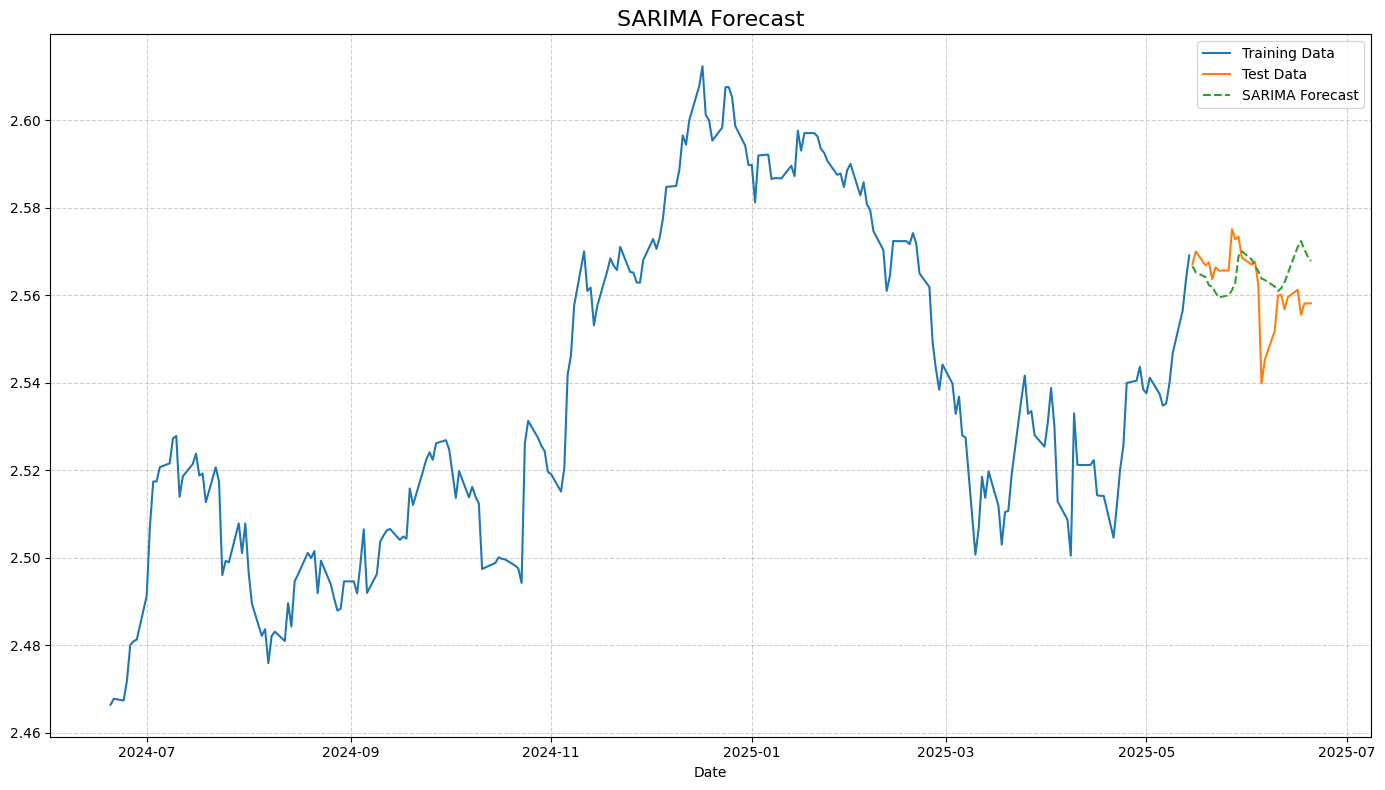

In [39]:
# Define SARIMA model parameters
p = 1    # AR order (based on PACF)
d = 1    # Differencing order (already differenced)
q = 0    # MA order (based on ACF)
P = 1    # Seasonal AR order
D = 1    # Seasonal differencing order
Q = 1    # Seasonal MA order
m = 12   # Seasonal period (monthly data)

# Fit the model
sarima_model_s = SARIMAX(train_s, 
                         order=(p, d, q), 
                         seasonal_order=(P, D, Q, m), 
                         enforce_stationarity=False, 
                         enforce_invertibility=False)
sarima_results_s = sarima_model_s.fit()

# Print model summary
print(sarima_results_s.summary())

# Forecasting
sarima_predictions_s = sarima_results_s.predict(start=len(train_s), end=len(close_diff_s)-1, dynamic=False)
# Align forecast index to test set
sarima_predictions_s.index = test_s.index

# Plot the forecast
plt.figure(figsize=(14, 8))
plt.plot(train_s, label="Training Data")
plt.plot(test_s, label="Test Data")
plt.plot(sarima_predictions_s, label="SARIMA Forecast", linestyle="--")
plt.title("SARIMA Forecast", fontsize=16)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Evaluation Metrics

In [40]:
# Calculate error metrics
mae_s = mean_absolute_error(test_s, sarima_predictions_s)
rmse_s = np.sqrt(mean_squared_error(test_s, sarima_predictions_s))
mape_s = mean_absolute_percentage_error(test_s, sarima_predictions_s)

print(f"MAE: {mae_s:.4f}")
print(f"RMSE: {rmse_s:.4f}")
print(f"MAPE: {mape_s:.4f}")

MAE: 0.0072
RMSE: 0.0093
MAPE: 0.0028


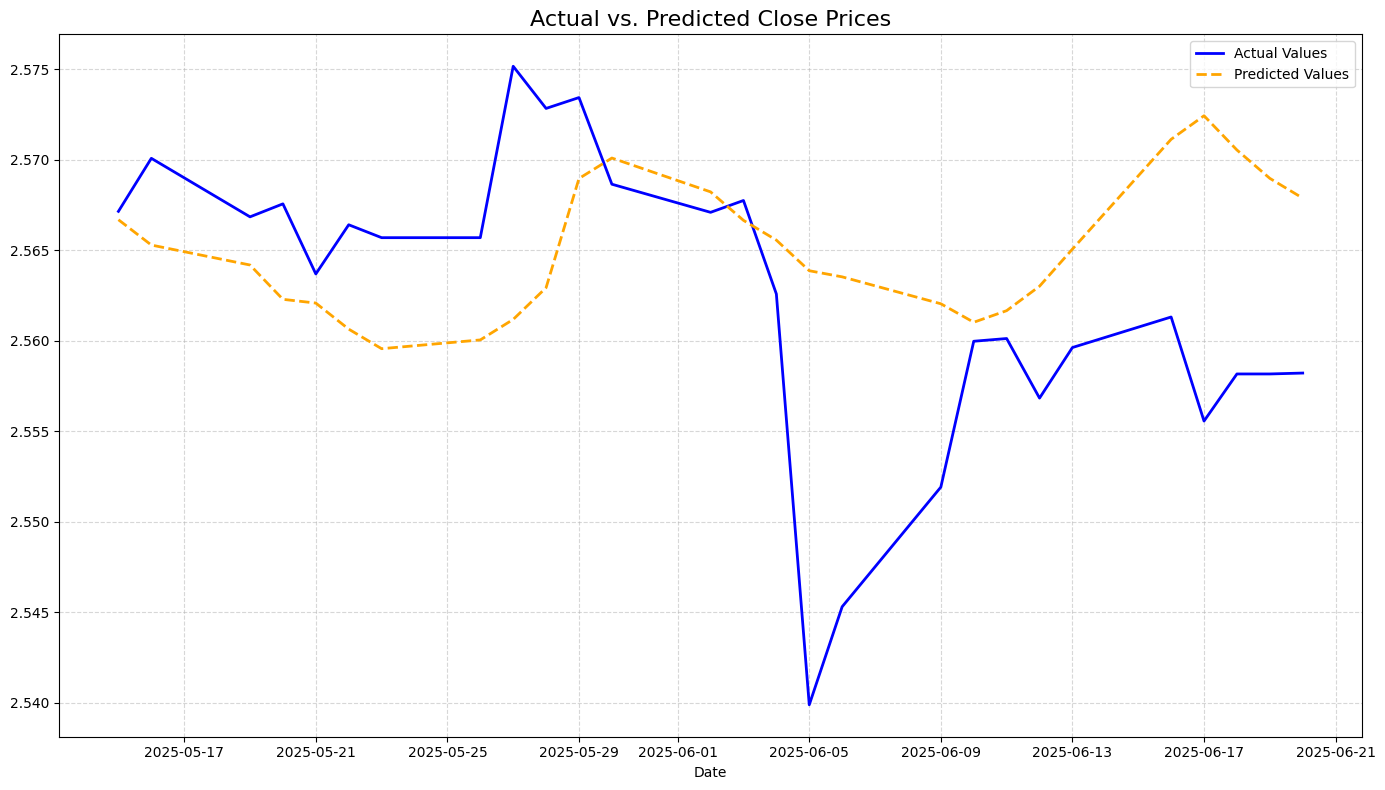

In [41]:
# Plot actual vs predicted values on test set
plt.figure(figsize=(14, 8))
plt.plot(test_s, label="Actual Values", color="blue", linewidth=2)
plt.plot(sarima_predictions_s, label="Predicted Values", color="orange", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted Close Prices", fontsize=16)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

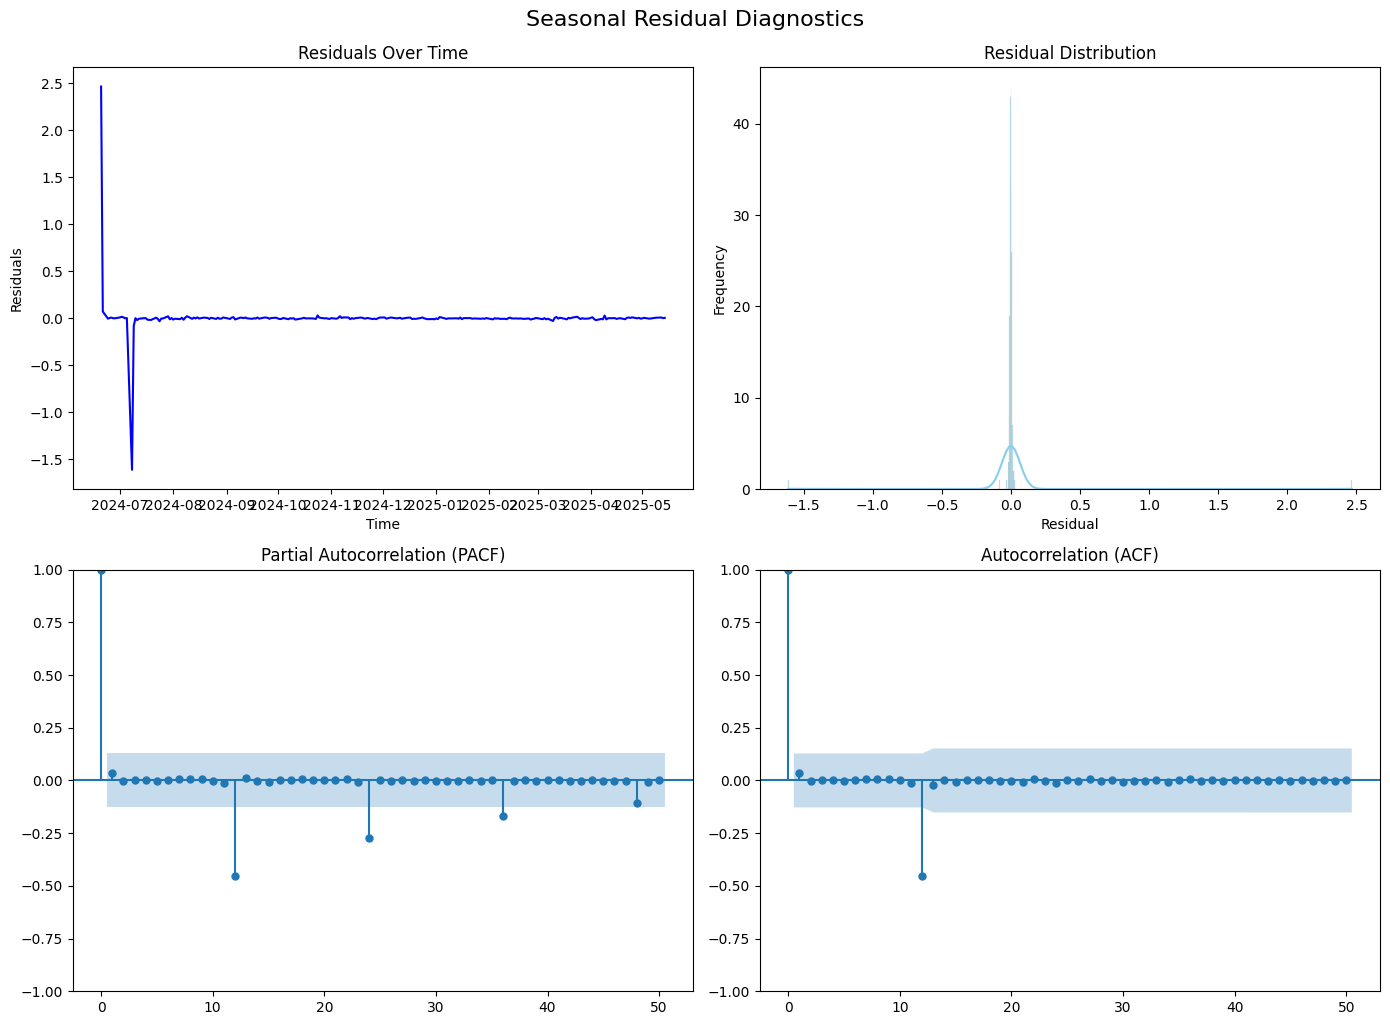

In [42]:
# Plot seasonal residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Line plot of residuals
axes[0, 0].plot(sarima_results_s.resid, color='blue')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# Histogram of residuals with KDE
sns.histplot(sarima_results_s.resid, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# PACF plot of residuals
plot_pacf(sarima_results_s.resid, lags=50, ax=axes[1, 0])
axes[1, 0].set_title("Partial Autocorrelation (PACF)")

# ACF plot of residuals
plot_acf(sarima_results_s.resid, lags=50, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation (ACF)")

plt.tight_layout()
plt.suptitle("Seasonal Residual Diagnostics", fontsize=16, y=1.02)
plt.show()


Overall, the model has performed well.
Need to apply additional models to catch high volatility for better predictions.

# Great, Now let's begin with part 2.

Now, Let's see how models perform for %change for close values using the error term.

## Calculate Percentage change for close

In [43]:
# Calculate daily percentage change for the 'Close' column
df_tesla_modified['Close_pct_change'] = df_tesla_modified['Close'].pct_change()

# Drop any NaN values (first row will be NaN due to the pct_change calculation)
df_tesla_modified.dropna(subset=['Close_pct_change'], inplace=True)
df_tesla_modified

,Open,High,Low,Close,Volume,Close_boxcox,Close_diff,Close_diff_12,Close_pct_change
2024-06-21,182.30,183.950,180.69,183.01,63029482.0,2.467832,0.001387,0.001153,0.007931
2024-06-24,184.97,188.800,182.55,182.58,61992070.0,2.467420,-0.000413,-0.003371,-0.002350
2024-06-25,184.40,187.970,182.01,187.35,63678265.0,2.471927,0.004507,0.004966,0.026126
2024-06-26,186.54,197.755,186.36,196.37,95737066.0,2.480046,0.008119,0.011855,0.048145
2024-06-27,195.17,198.720,194.05,197.42,72746521.0,2.480959,0.000913,0.004166,0.005347
...,...,...,...,...,...,...,...,...,...
2025-06-16,331.29,332.050,326.41,329.13,83925858.0,2.561307,0.001686,0.001086,0.011743
2025-06-17,326.09,327.260,314.74,316.35,88282669.0,2.555560,-0.005747,-0.000961,-0.038830
2025-06-18,317.31,329.320,315.45,322.05,95137686.0,2.558161,0.002601,0.004154,0.018018
2025-06-19,317.31,329.320,315.45,322.05,95137686.0,2.558161,0.000000,-0.000654,0.000000


## Checking Stationarity for Close % Change

### ADF Test for Close Percent Change

In [44]:
# Perform the ADF test
adf_result_pc = adfuller(df_tesla_modified['Close_pct_change'])

print('ADF Statistic:', adf_result_pc[0])     
print('p-value:', adf_result_pc[1])           
print("Critical Values:", adf_result_pc[4])   

# Check if the data is stationary
if adf_result_pc[1] < 0.05:
    print("\nThe data is stationary")
else:
    print("\nThe data is non-stationary")

ADF Statistic: -15.98967437671313
p-value: 6.692948998909009e-29
Critical Values: {'1%': np.float64(-3.4557539868570775), '5%': np.float64(-2.8727214497041422), '10%': np.float64(-2.572728476331361)}

The data is stationary


### KPSS Test for Close Percent Change

In [45]:
# Run KPSS test
kpss_result_pc = kpss(df_tesla_modified['Close_pct_change'], regression='ct', nlags="auto")

# Extracting and printing the results
print("KPSS Statistic:", kpss_result_pc[0])
print("p-value:", kpss_result_pc[1])
print("Critical Values:", kpss_result_pc[3])

# Check if the data is stationary
if kpss_result_pc[1] < 0.05:
    print("\nThe data is not stationary (reject H0).")
else:
    print("\nThe data is stationary (fail to reject H0).")

KPSS Statistic: 0.06542185720582964
p-value: 0.1
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is stationary (fail to reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/2726741590.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_pc = kpss(df_tesla_modified['Close_pct_change'], regression='ct', nlags="auto")


From the above results we can see that the data is stationary. 
No need to perform additional transformations.

## ACF & PACF for Close Percent Change

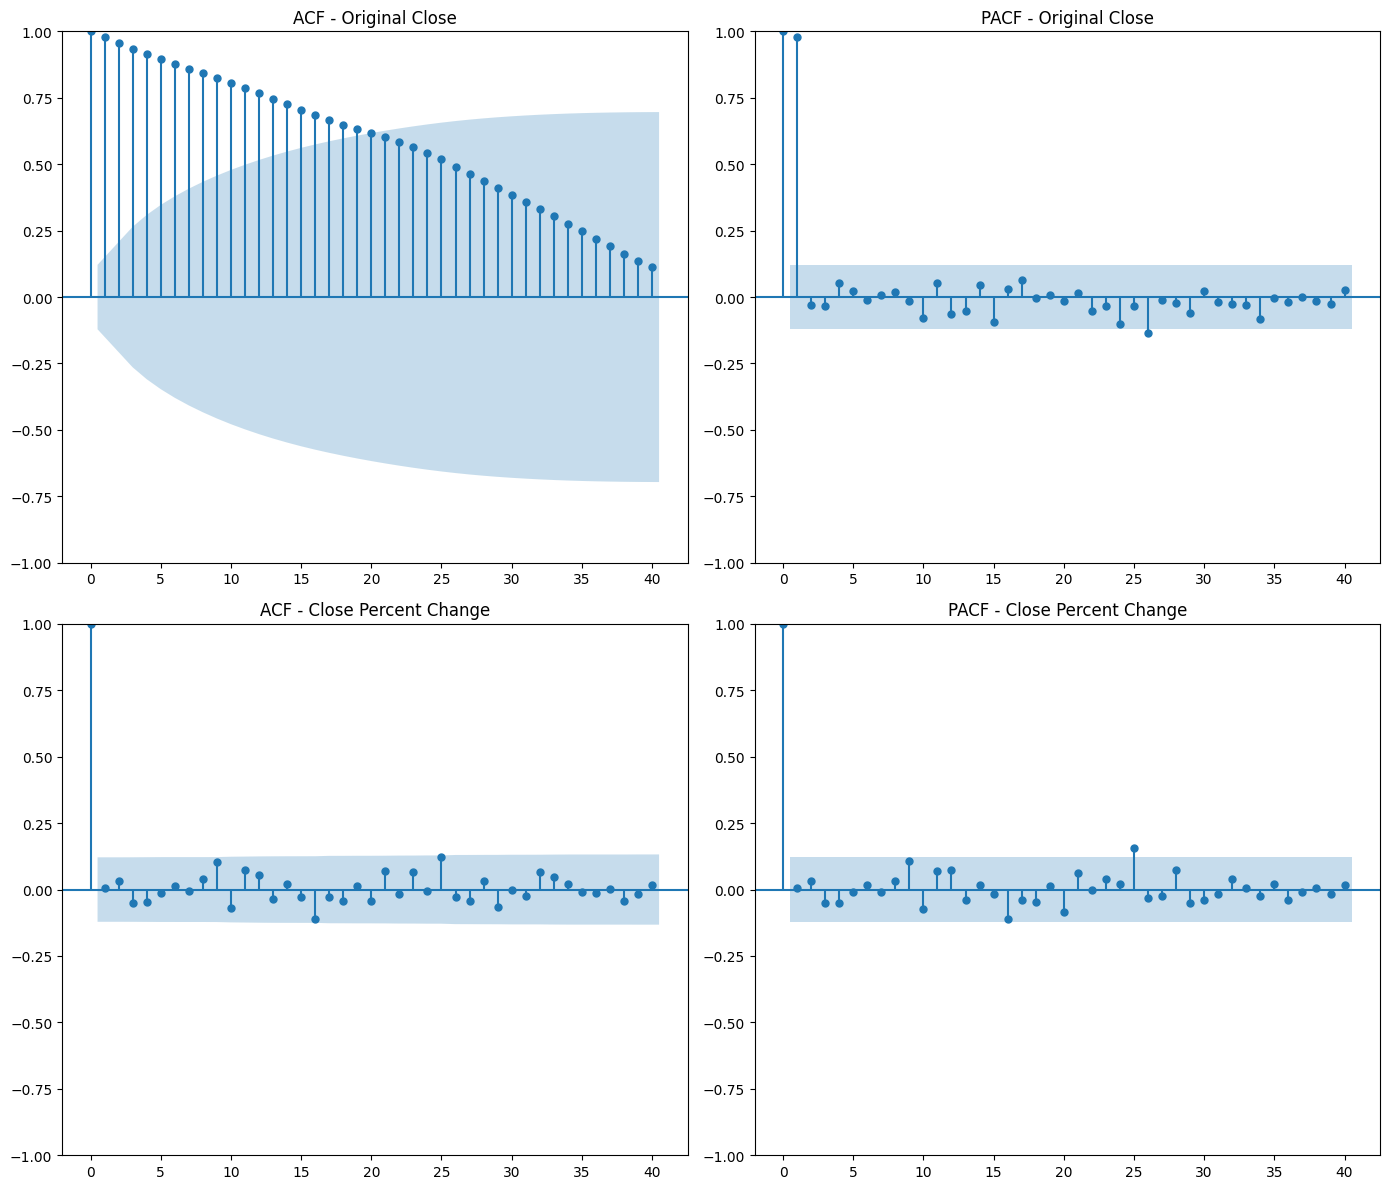

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Original Close
plot_acf(df_tesla_modified['Close'], lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Original Close")
plot_pacf(df_tesla_modified['Close'], lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Original Close")

# 2. Close Percent Change
plot_acf(df_tesla_modified['Close_pct_change'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF - Close Percent Change")
plot_pacf(df_tesla_modified['Close_pct_change'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF - Close Percent Change")

plt.tight_layout()
plt.show()

For ARIMA model will be using Close Percentage Change data, with p=1, d=0, q=0 from the above plots

## ARIMA Model

In [47]:
# Splitting data into training and test sets (e.g., last 10% for testing)
close_diff_pca = df_tesla_modified['Close_pct_change'].dropna()
train_size_pca = int(len(close_diff_pca) * 0.9)
train_pca, test_pca = close_diff_pca[:train_size_pca], close_diff_pca[train_size_pca:]

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:       Close_pct_change   No. Observations:                  234
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 386.746
Date:                Mon, 23 Jun 2025   AIC                           -761.492
Time:                        17:21:37   BIC                           -740.760
Sample:                    06-21-2024   HQIC                          -753.133
                         - 05-14-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.127      0.260      -0.003       0.010
ar.L1          0.8101      0.985      0.822      0.411      -1.121       2.741
ma.L1         -0.8022      0.99

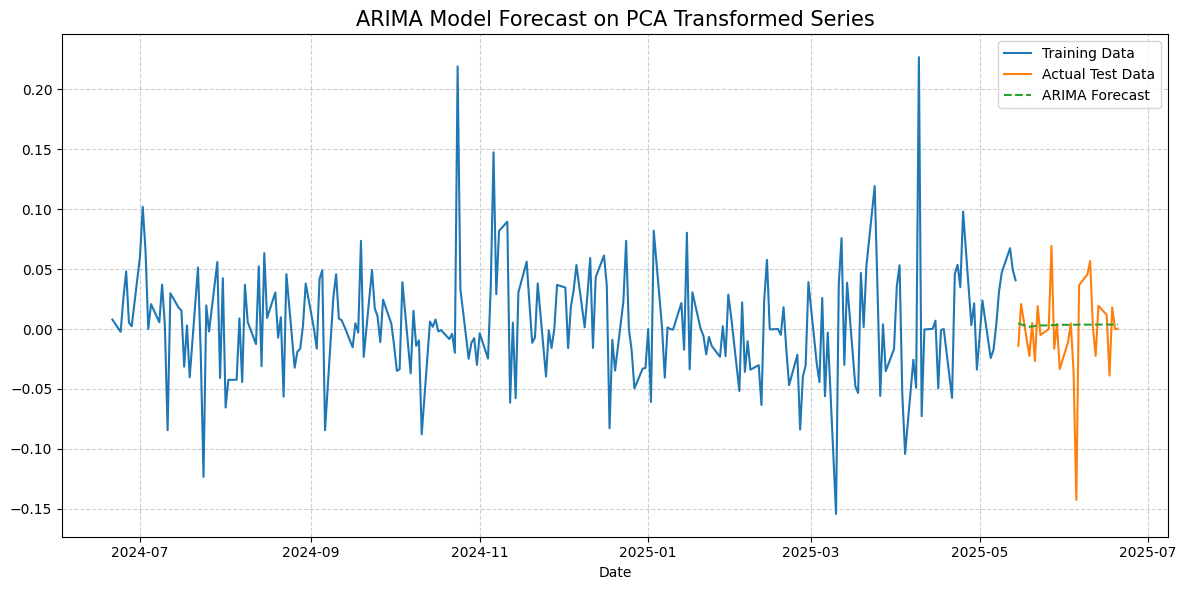

In [48]:
# Fit ARIMA Model on PCA Data
arima_model_pca = ARIMA(train_pca, order=(1,0,3)).fit()

# Display model summary
print("ARIMA Model Summary:")
print(arima_model_pca.summary())

# Forecasting
arima_predictions_pca = arima_model_pca.predict(start=len(train_pca), end=len(close_diff_pca)-1, dynamic=False)
# Align prediction index with test set
arima_predictions_pca.index = test_pca.index

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_pca, label="Training Data")
plt.plot(test_pca, label="Actual Test Data")
plt.plot(arima_predictions_pca, label="ARIMA Forecast", linestyle="--")
plt.title("ARIMA Model Forecast on PCA Transformed Series", fontsize=15)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Evaluation Metrics

In [49]:
# Calculate error metrics
mae_pca = mean_absolute_error(test_pca, arima_predictions_pca)
rmse_pca = np.sqrt(mean_squared_error(test_pca, arima_predictions_pca))
mape_pca = mean_absolute_percentage_error(test_pca, arima_predictions_pca)

print(f"MAE: {mae_pca:.4f}")
print(f"RMSE: {rmse_pca:.4f}")
print(f"MAPE: {mape_pca:.4f}")

MAE: 0.0255
RMSE: 0.0387
MAPE: 1142435332254.1140


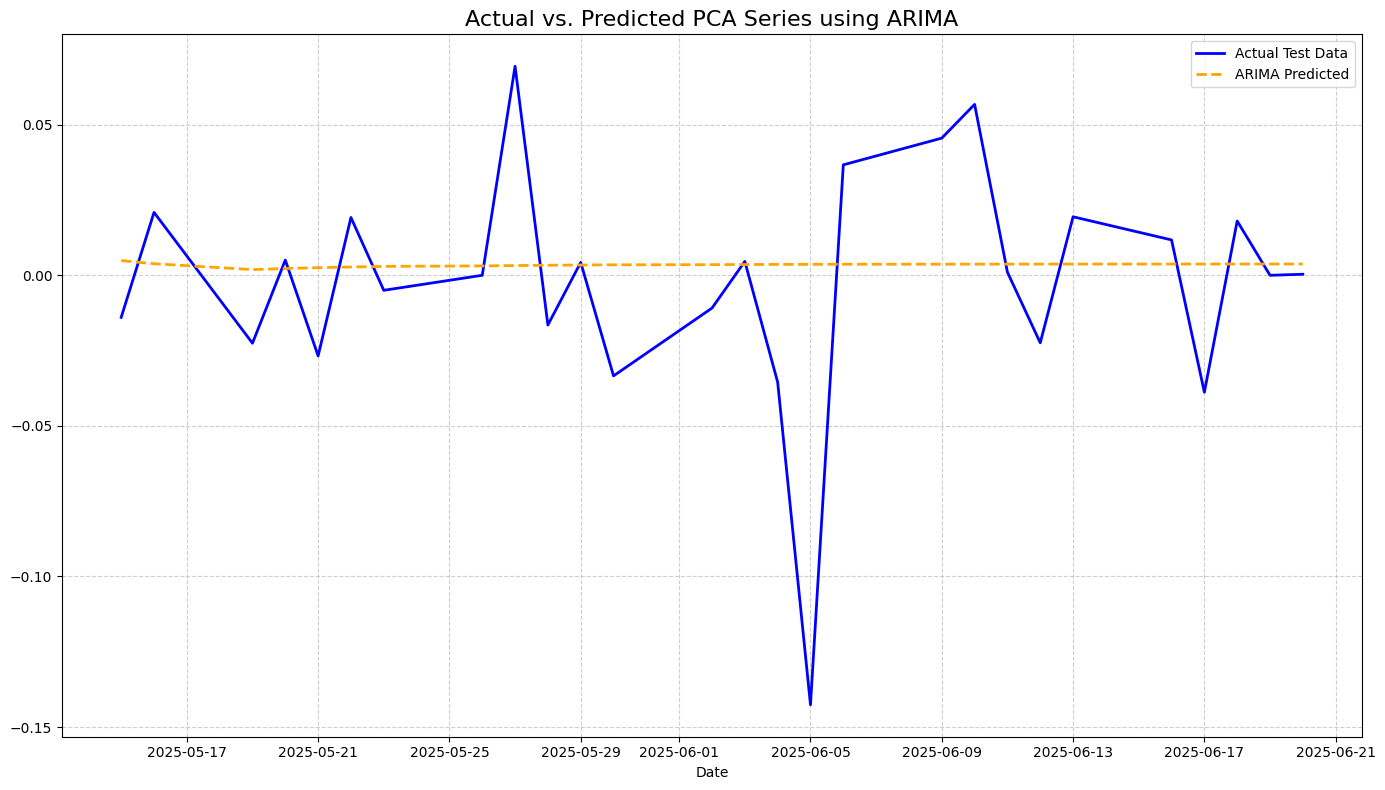

In [50]:
plt.figure(figsize=(14, 8))
plt.plot(test_pca, label="Actual Test Data", color="blue", linewidth=2)
plt.plot(arima_predictions_pca, label="ARIMA Predicted", color="orange", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted PCA Series using ARIMA", fontsize=16)
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

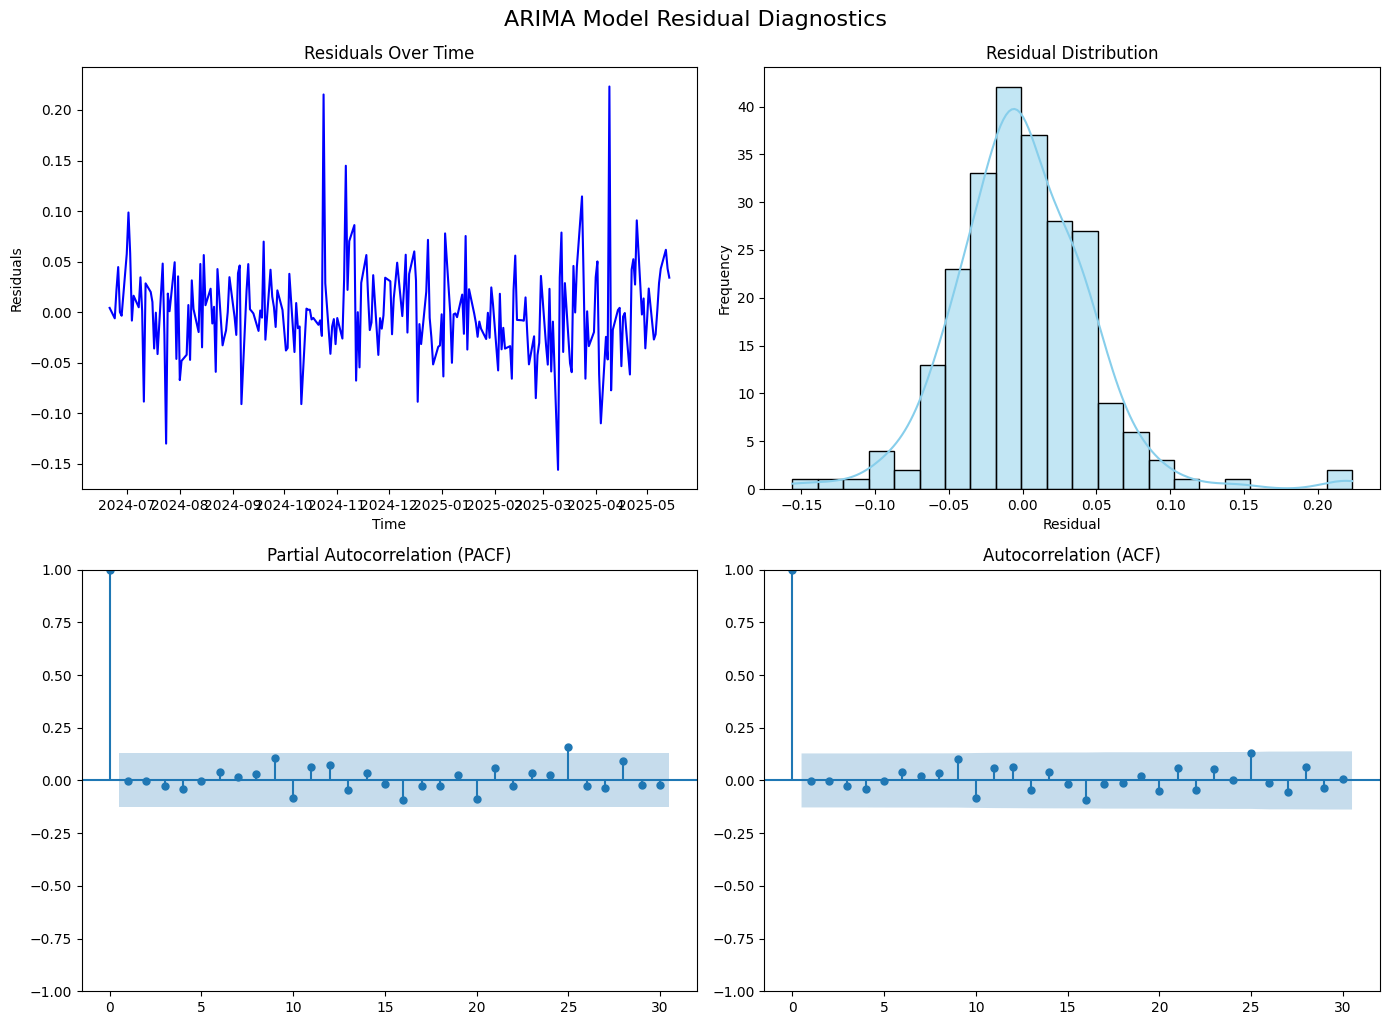

In [51]:
# Plot residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(arima_model_pca.resid, color='blue')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# 2. Histogram with KDE
sns.histplot(arima_model_pca.resid, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# 3. PACF
plot_pacf(arima_model_pca.resid, lags=30, ax=axes[1, 0])
axes[1, 0].set_title("Partial Autocorrelation (PACF)")

# 4. ACF
plot_acf(arima_model_pca.resid, lags=30, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation (ACF)")

plt.tight_layout()
plt.suptitle("ARIMA Model Residual Diagnostics", fontsize=16, y=1.02)
plt.show()


The results performed better with q=3, instead of q=0.

## Now, Lets start Seasonal transformation for Close Percent Change

### Seasonal differencing

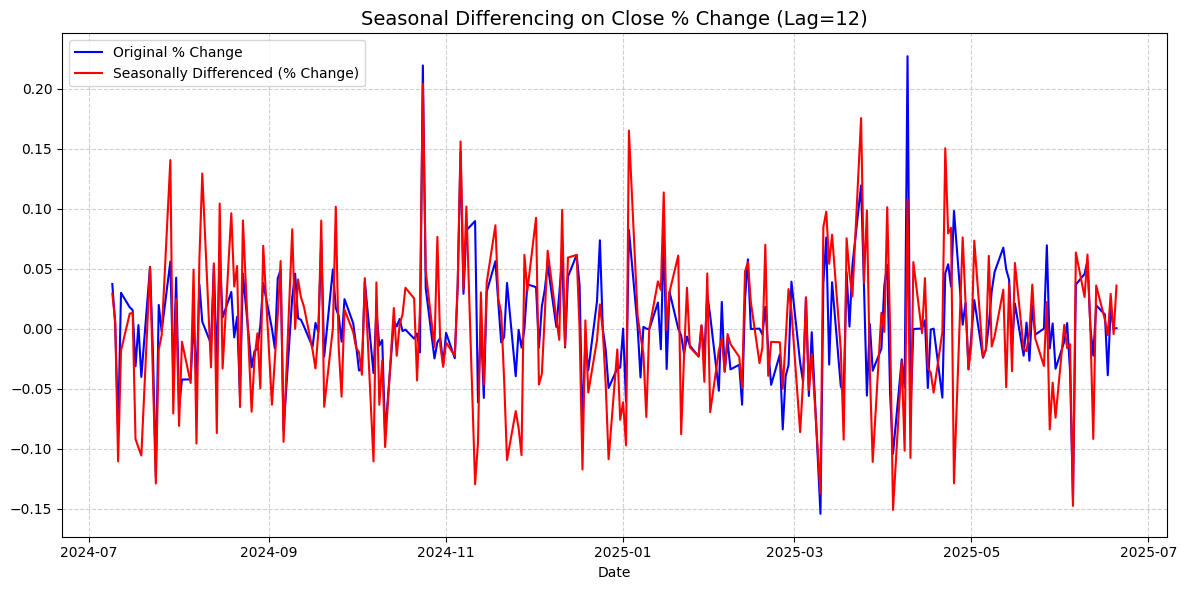

,Open,High,Low,Close,Volume,Close_boxcox,Close_diff,Close_diff_12,Close_pct_change,Close_pct_diff_12
2024-07-09,251.00,265.61,250.3000,262.33,160742516.0,2.527333,0.005703,0.004316,0.037123,0.029193
2024-07-10,262.80,267.59,257.8600,263.26,128519430.0,2.527883,0.000550,0.000963,0.003545,0.005895
2024-07-11,263.30,271.00,239.6500,241.03,221707273.0,2.513976,-0.013907,-0.018415,-0.084441,-0.110567
2024-07-12,235.80,251.84,233.0912,248.23,155955773.0,2.518662,0.004686,-0.003433,0.029872,-0.018273
2024-07-15,255.97,265.60,251.7300,252.64,146912920.0,2.521443,0.002781,0.001869,0.017766,0.012419
...,...,...,...,...,...,...,...,...,...,...
2025-06-16,331.29,332.05,326.4100,329.13,83925858.0,2.561307,0.001686,0.001086,0.011743,0.007456
2025-06-17,326.09,327.26,314.7400,316.35,88282669.0,2.555560,-0.005747,-0.000961,-0.038830,-0.005434
2025-06-18,317.31,329.32,315.4500,322.05,95137686.0,2.558161,0.002601,0.004154,0.018018,0.028900
2025-06-19,317.31,329.32,315.4500,322.05,95137686.0,2.558161,0.000000,-0.000654,0.000000,-0.004611


In [52]:
# Apply seasonal differencing to percentage change series
df_tesla_modified['Close_pct_diff_12'] = df_tesla_modified['Close_pct_change'].diff(12)
df_tesla_modified.dropna(subset=['Close_pct_diff_12'], inplace=True)

# Plot original % change and seasonal differenced series
plt.figure(figsize=(12, 6))

plt.plot(df_tesla_modified['Close_pct_change'], label='Original % Change', color='blue', linewidth=1.5)
plt.plot(df_tesla_modified['Close_pct_diff_12'], label='Seasonally Differenced (% Change)', color='red', linewidth=1.5)
plt.title('Seasonal Differencing on Close % Change (Lag=12)', fontsize=14)
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

df_tesla_modified

## Checking Stationarity for Seasonal Close % Change data

### ADF test on pct Seasonal data

In [53]:
adf_result_pct_diff12 = adfuller(df_tesla_modified['Close_pct_diff_12'])

print(f"ADF Statistic: {adf_result_pct_diff12[0]}")
print(f"p-value: {adf_result_pct_diff12[1]}")
print(f"Critical Values: {adf_result_pct_diff12[4]}")

# Interpret the result
if adf_result_pct_diff12[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is non-stationary")

ADF Statistic: -6.284786528051146
p-value: 3.7208871674917475e-08
Critical Values: {'1%': np.float64(-3.458731141928624), '5%': np.float64(-2.8740258764297293), '10%': np.float64(-2.5734243167124093)}
The data is stationary


### KPSS test on pct Seasonal data

In [54]:
kpss_result_pct_diff12 = kpss(df_tesla_modified['Close_pct_diff_12'], regression='c', nlags="auto")

# Extracting and printing the results
print(f"KPSS Statistic: {kpss_result_pct_diff12[0]:.6f}")
print(f"p-value: {kpss_result_pct_diff12[1]:.4f}")
print("Critical Values:", kpss_result_pct_diff12[3])

# Check if the data is stationary
if kpss_result_pct_diff12[1] < 0.05:
    print("The data is not stationary (reject H0).")
else:
    print("The data is stationary (fail to reject H0).")

KPSS Statistic: 0.052945
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is stationary (fail to reject H0).


/var/folders/k7/tnl417hj2zjdv1_mzsxbsz_h0000gn/T/ipykernel_60267/1188508883.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_pct_diff12 = kpss(df_tesla_modified['Close_pct_diff_12'], regression='c', nlags="auto")


From the above results we can see that the data is seasonal stationary.

## ACF & PACF plot for pct Seasonal data

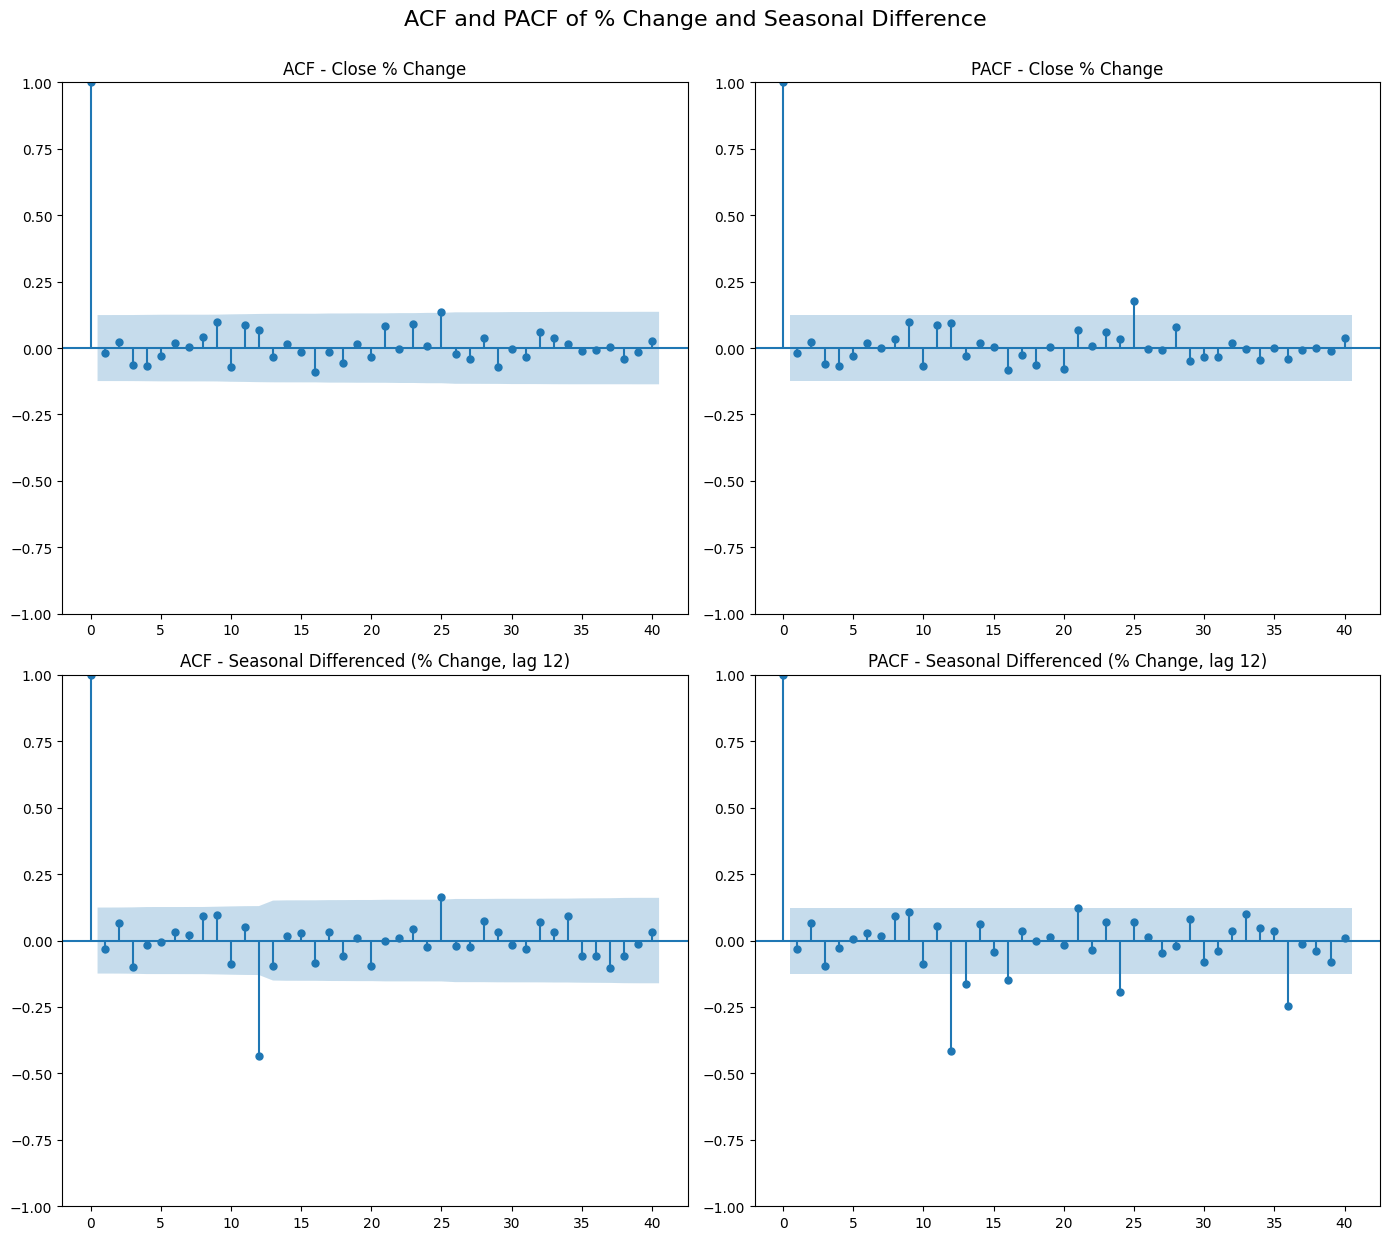

In [55]:
# Create 2x2 grid for ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Close Percent Change
plot_acf(df_tesla_modified['Close_pct_change'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Close % Change")
plot_pacf(df_tesla_modified['Close_pct_change'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Close % Change")

# 2. Seasonal Differenced Percent Change
plot_acf(df_tesla_modified['Close_pct_diff_12'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF - Seasonal Differenced (% Change, lag 12)")
plot_pacf(df_tesla_modified['Close_pct_diff_12'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF - Seasonal Differenced (% Change, lag 12)")

plt.tight_layout()
plt.suptitle("ACF and PACF of % Change and Seasonal Difference", fontsize=16, y=1.03)
plt.show()


For SARIMA Model, will be using Seasonal Differenced % change data for P=1, D=1, Q=1, m=12 from the above plots.

## SARIMA Model pct

In [56]:
#Splitting data into training and test sets (e.g., last 10% for testing)
close_diff_p_s = df_tesla_modified['Close_pct_diff_12'].dropna()
train_size_p_s = int(len(close_diff_p_s) * 0.9)
train_p_s, test_p_s = close_diff_p_s[:train_size_p_s], close_diff_p_s[train_size_p_s:]

                                      SARIMAX Results                                       
Dep. Variable:                    Close_pct_diff_12   No. Observations:                  224
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                 269.507
Date:                              Mon, 23 Jun 2025   AIC                           -525.014
Time:                                      17:21:39   BIC                           -502.068
Sample:                                  07-09-2024   HQIC                          -515.724
                                       - 05-16-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3314      0.713      0.465      0.642      -1.066       1.728
ma.L1         -0.43

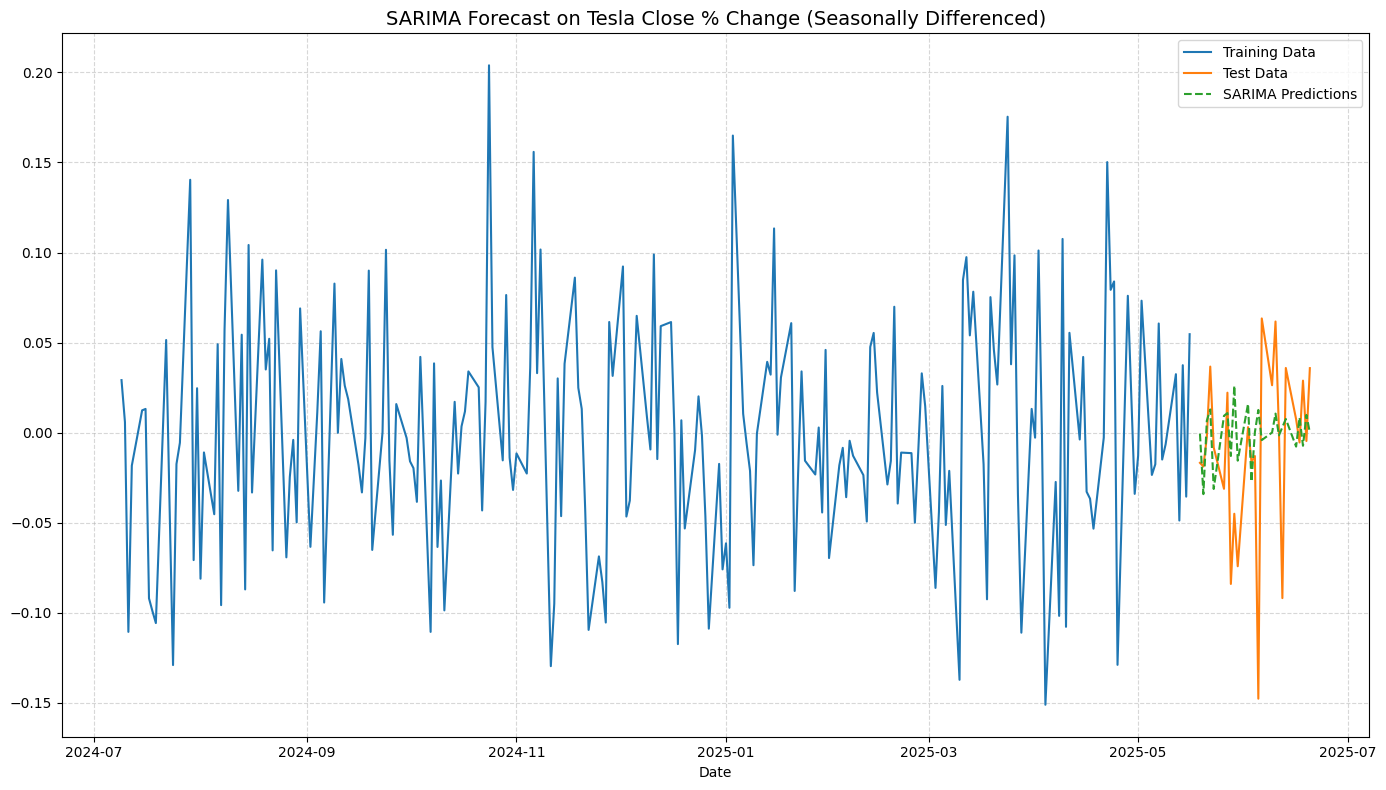

In [57]:
# Define SARIMA model parameters
p = 1    # AR order (based on PACF)
d = 0    # Differencing order (already differenced)
q = 3    # MA order (based on ACF)
P = 1    # Seasonal AR order
D = 1    # Seasonal differencing order
Q = 1    # Seasonal MA order
m = 12   # Seasonal period (monthly data)

# Fit the model
sarima_model_p_s = SARIMAX(train_p_s, 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, m), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_results_p_s = sarima_model_p_s.fit()

# Print model summary
print(sarima_results_p_s.summary())

# Forecasting
sarima_predictions_p_s = sarima_results_p_s.predict(start=len(train_p_s), end=len(close_diff_p_s)-1, dynamic=False)
# Align index for predictions
sarima_predictions_p_s.index = test_p_s.index

# Plot the forecast
plt.figure(figsize=(14, 8))
plt.plot(train_p_s, label="Training Data")
plt.plot(test_p_s, label="Test Data")
plt.plot(sarima_predictions_p_s, label="SARIMA Predictions", linestyle="--")
plt.title('SARIMA Forecast on Tesla Close % Change (Seasonally Differenced)', fontsize=14)
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation Metrics

In [58]:
mae_p_s = mean_absolute_error(test_p_s, sarima_predictions_p_s)
rmse_p_s = np.sqrt(mean_squared_error(test_p_s, sarima_predictions_p_s))
mape_p_s = mean_absolute_percentage_error(test_p_s, sarima_predictions_p_s)

print(f"MAE: {mae_p_s:.4f}")
print(f"RMSE: {rmse_p_s:.4f}")
print(f"MAPE: {mape_p_s:.4f}")

MAE: 0.0370
RMSE: 0.0506
MAPE: 1.5182


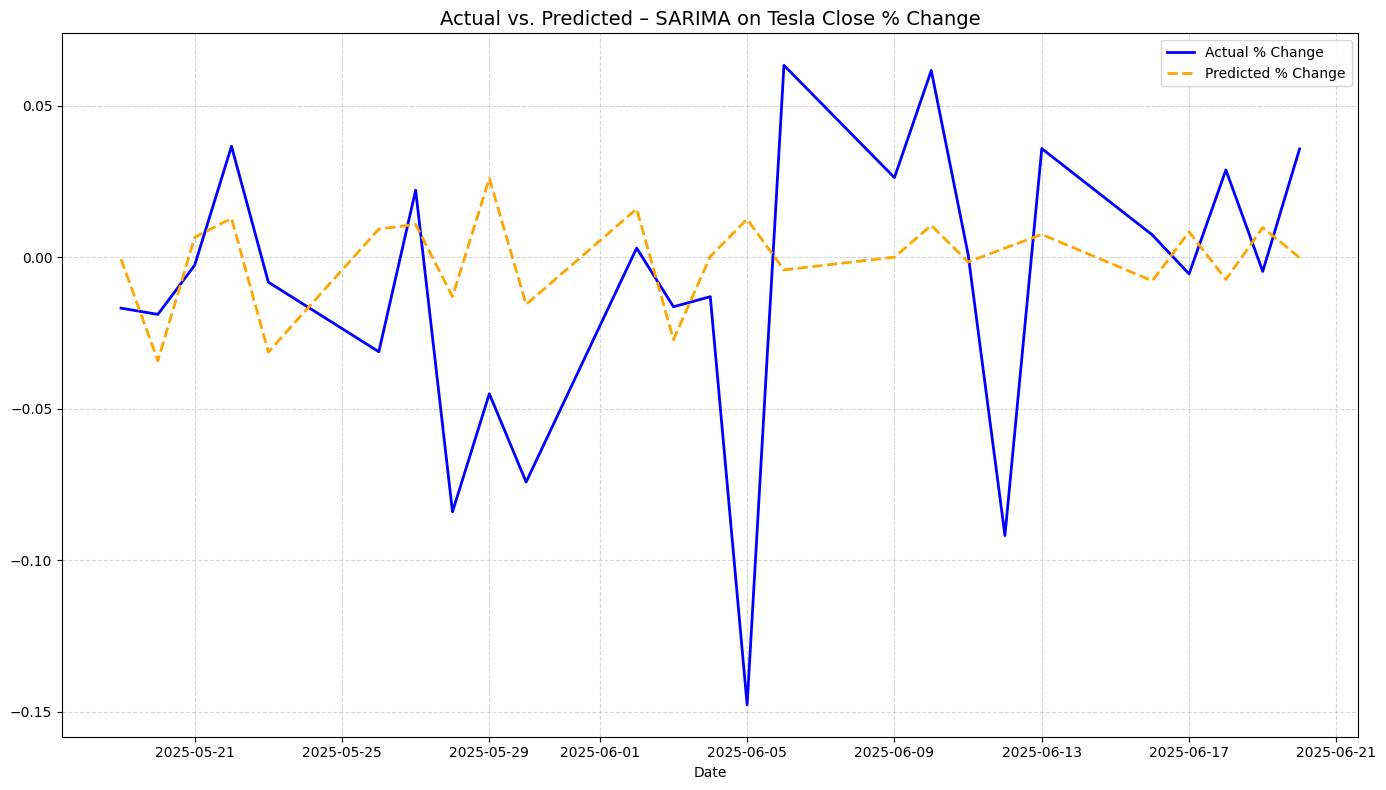

In [59]:
# Plot Actual vs Predicted values
plt.figure(figsize=(14, 8))
plt.plot(test_p_s, label="Actual % Change", color="blue", linewidth=2)
plt.plot(sarima_predictions_p_s, label="Predicted % Change", color="orange", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted – SARIMA on Tesla Close % Change", fontsize=14)
plt.xlabel("Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

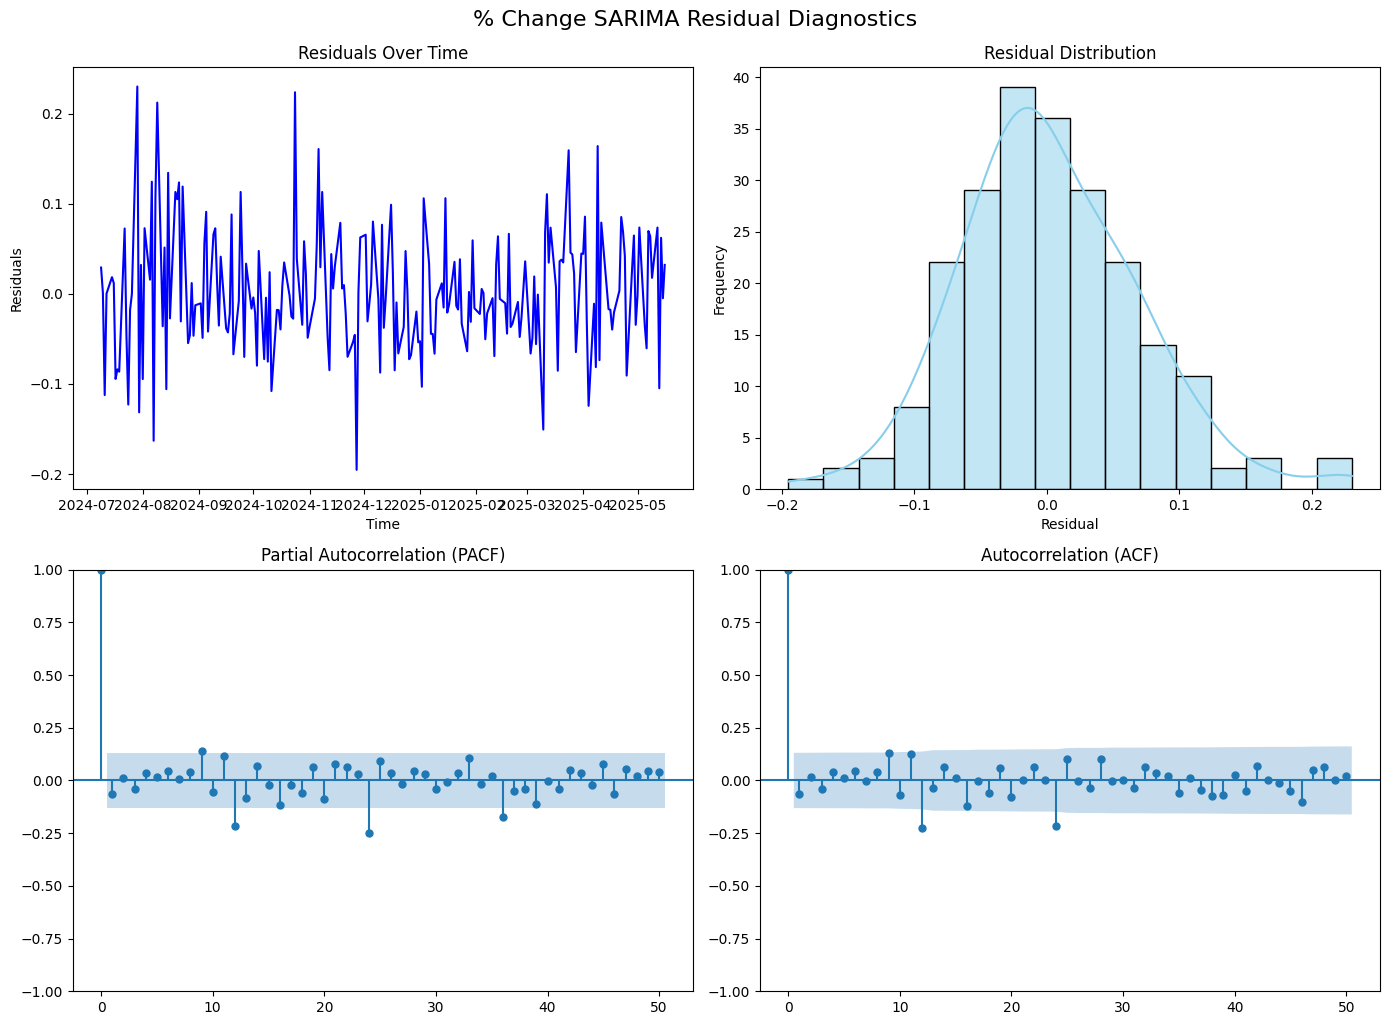

In [60]:
# Plot seasonal residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Line plot of residuals
axes[0, 0].plot(sarima_results_p_s.resid, color='blue')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")

# 2. Histogram with KDE
sns.histplot(sarima_results_p_s.resid, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title("Residual Distribution")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# 3. PACF plot
plot_pacf(sarima_results_p_s.resid, lags=50, ax=axes[1, 0], method='ywm')
axes[1, 0].set_title("Partial Autocorrelation (PACF)")

# 4. ACF plot
plot_acf(sarima_results_p_s.resid, lags=50, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation (ACF)")

# Layout and title
plt.tight_layout()
plt.suptitle("% Change SARIMA Residual Diagnostics", fontsize=16, y=1.02)
plt.show()


Model did perform slighlty better with Q=2.

# Conclusion

This project focused on time series analysis and forecasting of Tesla's stock prices using ARIMA and SARIMA models, applied to both the Close price and the percentage change in Close. The objective was to evaluate how well these statistical models could capture patterns and provide reliable forecasts for financial decision-making. 

We began by transforming the data for stationarity, applying techniques such as differencing and Box-Cox transformation. ACF and PACF plots guided the selection of model parameters, and seasonality was specifically addressed through SARIMA modeling.

| Dataset            | Model  | MAE    | RMSE   | MAPE     |
| ------------------ | ------ | ------ | ------ | -------- |
| **Close**          | ARIMA  | 0.0062 | 0.0079 | 0.0024   |
|                    | SARIMA | 0.0072 | 0.0093 | 0.0028   |
| **Close % Change** | ARIMA  | 0.0255 | 0.0387 | 1.14e+12 |
|                    | SARIMA | 0.0370 | 0.0506 | 1.5182   |


For the Close price, both ARIMA and SARIMA models performed well, with ARIMA slightly outperforming SARIMA across all metrics. The ARIMA residuals displayed minimal fluctuation, and the residual distribution was bell-shaped and symmetrical, indicating a good fit. SARIMA also showed acceptable performance but exhibited a minor dip in residuals early in the time series.

For the Close % Change, model accuracy was noticeably lower. Both models showed more fluctuation in the residual plots, suggesting the presence of noise and complexity in the daily return data that may not be fully captured by ARIMA/SARIMA models. The residual distributions, however, remained bell-shaped, confirming some degree of normality.

Key Takeaways:

- ARIMA is effective for modeling Tesla’s Close prices and yields strong predictive performance.

- SARIMA is beneficial for handling seasonal data but showed slightly lower accuracy than ARIMA in this case.

- Forecasting percentage changes is more volatile and less predictable, as indicated by higher MAE, RMSE, and extreme MAPE values.

- Residual analysis confirmed that all models produced reasonably normal residuals, reinforcing the validity of model assumptions.



While ARIMA and SARIMA are solid classical methods, future analysis could explore more robust models like Prophet, LSTM, or XGBoost to better capture complex dynamics, especially in high-frequency or noisy financial data like percentage changes.